### imports 

In [18]:
import os
from os import path
import configparser
from github import Github
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import datetime
from datetime import datetime
from datetime import timezone
from ast import literal_eval
import requests
from requests.adapters import HTTPAdapter, Retry

In [2]:
import githubanalysis.processing.repo_name_clean as name_clean
import githubanalysis.processing.get_repo_connection as ghconnect
import githubanalysis.processing.setup_github_auth as ghauth
import githubanalysis.processing.get_all_pages_issues as getallissues
import githubanalysis.processing.get_issue_assignees as get_assignee
import githubanalysis.analysis.calc_days_since_repo_creation as dayssince
import githubanalysis.processing.summarise_repo_stats
from githubanalysis.processing.summarise_repo_stats import RepoStatsSummariser
import utilities.get_default_logger as loggit
import utilities.chunker as chunker

### access token 

In [3]:
# set up github access token with github package: 

config = configparser.ConfigParser()
config.read('../config.cfg')
config.sections()

access_token = config['ACCESS']['token']
g = Github(access_token) 

gh_token = ghauth.setup_github_auth(config_path='../../githubanalysis/config.cfg')
headers = {f"Authorization: Bearer {gh_token}"}

## Big20Top10 Repos

In [8]:
repo_list = [
    'Dallinger/Dallinger',
    'Axelrod-Python/Axelrod',
    'CICE-Consortium/CICE',
    'MPAS-Dev/compass',
    'kinverarity1/lasio',
    'astrorama/SourceXtractorPlusPlus',
    'CICE-Consortium/Icepack',
    'NOAA-GFDL/MDTF-diagnostics',
    'uwescience/pulse2percept',
    'JeschkeLab/DeerLab'
    ]

In [177]:
# get stats from gh_stats for big20top10: 
gh_stats = pd.read_csv('../../data/gh_stats_2024-02-14.csv', header=0)
gh_stats

big20top10stats = gh_stats.loc[gh_stats['repo_name'].isin(repo_list)]
big20top10stats

,repo_name,initial_HTTP_code,issues_enabled,repo_is_fork,devs,total_commits_last_year,has_PRs,last_PR_update,open_tickets,closed_tickets,repo_age_days,repo_license,repo_visibility,repo_language
138,NOAA-GFDL/MDTF-diagnostics,200,True,False,19.0,47.0,True,2024-02-05 19:05:54+00:00,35.0,406.0,1722.0,NOASSERTION,True,"dict_keys(['Python', 'NCL', 'HTML', 'Shell', '..."
864,Dallinger/Dallinger,200,True,False,30.0,237.0,True,2024-02-14 12:09:17+00:00,357.0,5822.0,2717.0,MIT,True,"dict_keys(['Python', 'HTML', 'JavaScript', 'Ji..."
1113,Axelrod-Python/Axelrod,200,True,False,83.0,7.0,True,2024-02-07 07:53:03+00:00,58.0,1375.0,3283.0,NOASSERTION,True,"dict_keys(['Python', 'Shell'])"
1266,astrorama/SourceXtractorPlusPlus,200,True,False,14.0,35.0,True,2024-01-24 14:05:09+00:00,48.0,514.0,2344.0,LGPL-3.0,True,"dict_keys(['C++', 'Python', 'CMake', 'C', 'Mak..."
1339,MPAS-Dev/compass,200,True,False,31.0,626.0,True,2024-02-14 12:18:58+00:00,43.0,729.0,1195.0,NOASSERTION,True,"dict_keys(['Python', 'Shell'])"
1345,JeschkeLab/DeerLab,200,True,False,7.0,24.0,True,2023-11-03 11:20:13+00:00,5.0,450.0,1320.0,MIT,True,"dict_keys(['Python', 'HTML', 'Batchfile', 'Mak..."
1436,CICE-Consortium/Icepack,200,True,False,25.0,38.0,True,2024-02-13 16:21:36+00:00,27.0,455.0,2457.0,NOASSERTION,True,"dict_keys(['Fortran', 'Shell', 'C', 'Makefile'..."
1633,kinverarity1/lasio,200,True,False,34.0,13.0,True,2023-11-17 21:09:23+00:00,50.0,516.0,3704.0,MIT,True,"dict_keys(['Lasso', 'Python', 'Jupyter Noteboo..."
1738,CICE-Consortium/CICE,200,True,False,25.0,62.0,True,2024-02-13 19:43:35+00:00,73.0,858.0,2457.0,NOASSERTION,True,"dict_keys(['Fortran', 'Shell', 'Python', 'Type..."
1818,uwescience/pulse2percept,200,True,False,31.0,53.0,True,2024-01-29 23:32:18+00:00,38.0,569.0,2961.0,BSD-3-Clause,True,"dict_keys(['Python', 'Cython', 'Makefile'])"


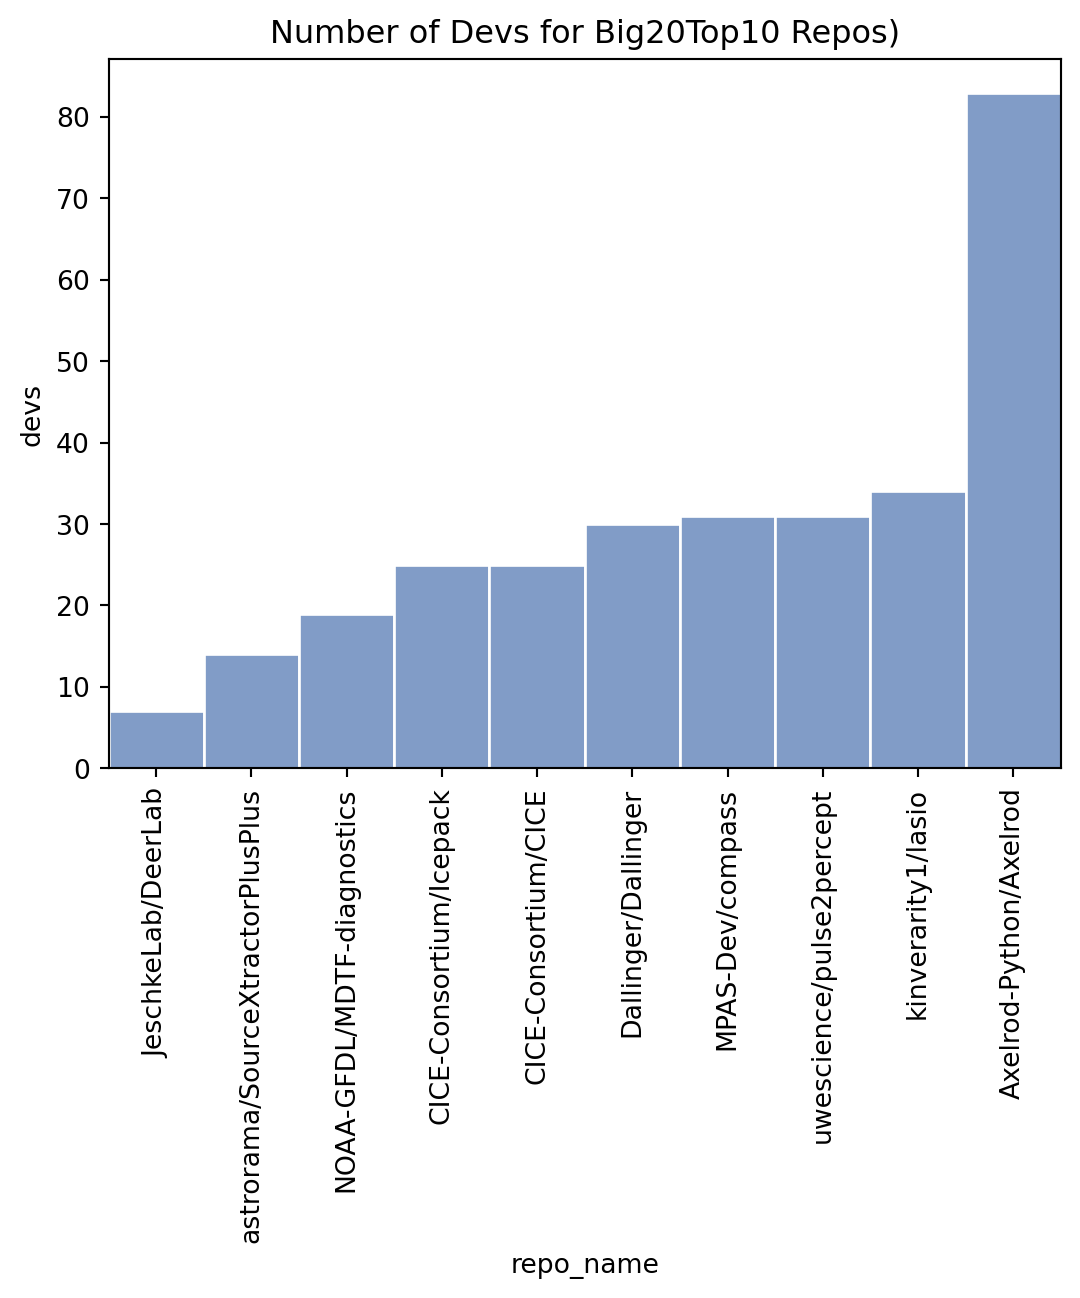

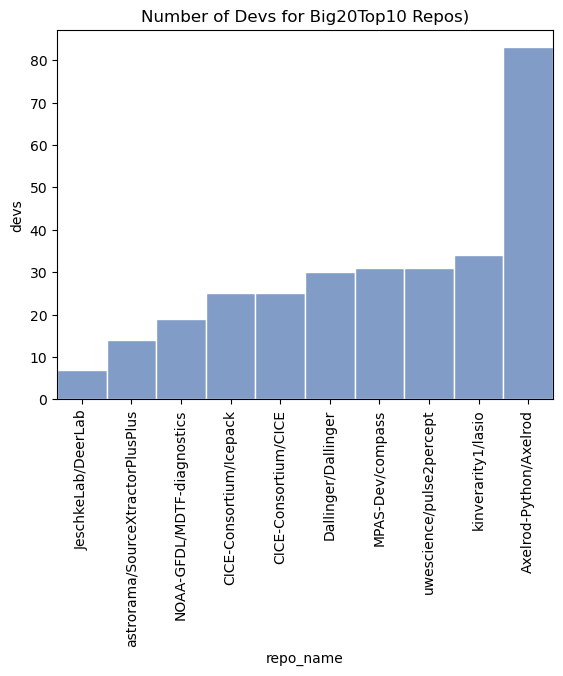

In [243]:
fig, ax = plt.subplots()
ax.xaxis.set_tick_params(rotation=90)  # rotated xlabels via: https://stackoverflow.com/a/75039104

ordered = big20top10stats.sort_values(['devs']).reset_index()

(so.Plot(
    data=ordered,
    x='repo_name', 
    y='devs' 
).add(so.Bars())
 .label(title="Number of Devs for Big20Top10 Repos)")
 .on(ax)
)


In [231]:
lotsdevs = big20top10stats[big20top10stats['devs'] > 80]
print(f"{lotsdevs.iloc[0]['repo_name']} is the repo with more than 80 devs")

Axelrod-Python/Axelrod is the repo with more than 80 devs


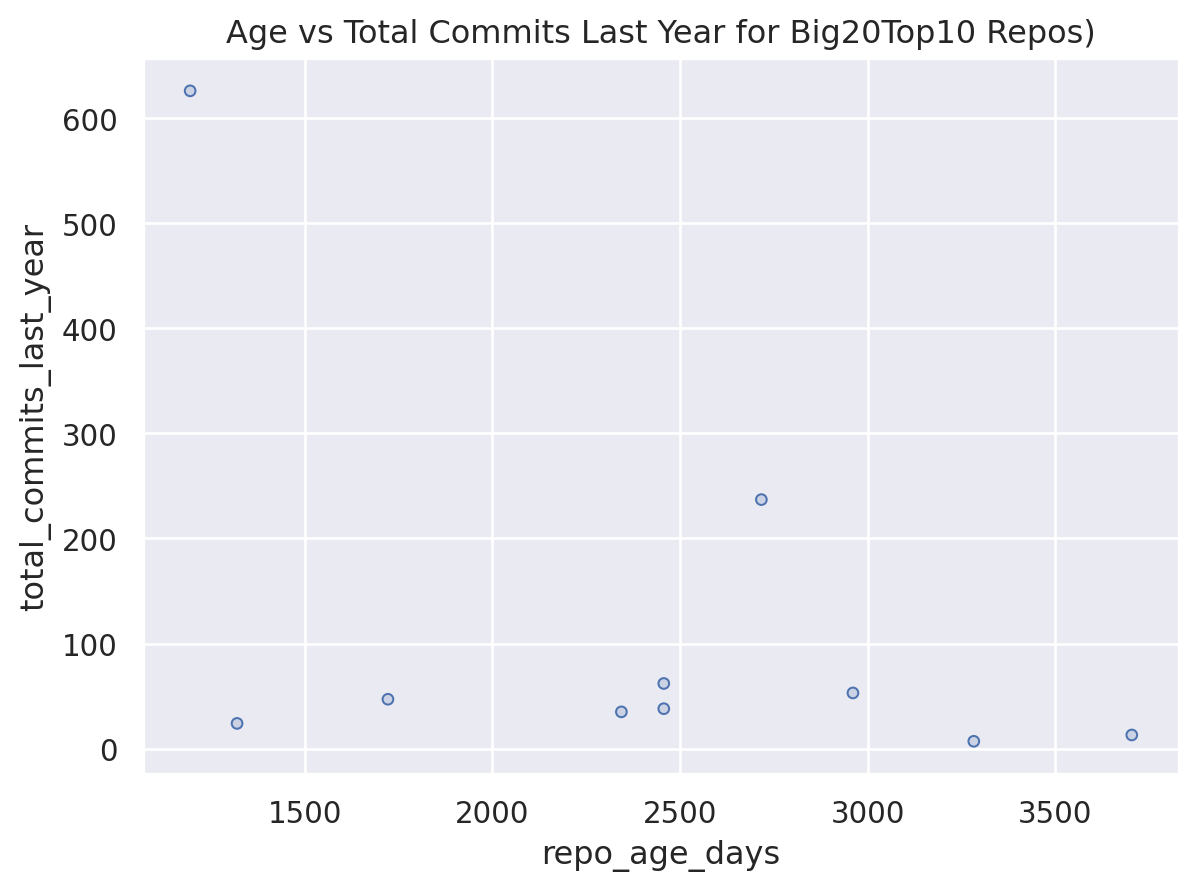

In [189]:

(so.Plot(
    data=big20top10stats,
    x='repo_age_days',
    y='total_commits_last_year'
).add(so.Dots())
 .label(title="Age vs Total Commits Last Year for Big20Top10 Repos)")
)


In [219]:
lotscommits = big20top10stats[big20top10stats['total_commits_last_year'] > 600]
print(f"{lotscommits.iloc[0]['repo_name']} is the repo with more than 600 commits last year")

other_larger = big20top10stats[big20top10stats['total_commits_last_year'] > 200]
other_larger = other_larger[other_larger['total_commits_last_year'] < 300]

print(f"{other_larger.iloc[0]['repo_name']} is the repo with between 200-300 commits last year")

MPAS-Dev/compass is the repo with more than 600 commits last year
Dallinger/Dallinger is the repo with between 200-300 commits last year


## Run get_all_pages_issues( ) and get_repo_contributors( ) for all big20top10

In [10]:
for item in repo_list:
    sanitised_repo_name = item.replace("/", "-")
    iss_df = issues_getter.get_all_pages_issues(repo_name=item, config_path='../../githubanalysis/config.cfg', out_filename='all-issues', write_out_location='../../data/')
    devs_df = devs_getter.get_repo_contributors(repo_name=item, config_path='../../githubanalysis/config.cfg', out_filename='contributors', write_out_location='../../data/')


INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 1 of 63.
INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 2 of 63.
INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 3 of 63.
INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 4 of 63.
INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 5 of 63.
INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 6 of 63.
INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 7 of 63.
INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 8 of 63.
INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 9 of 63.
INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 10 of 63.
INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 11 of 63.
INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 12 of 63.
INFO:>> Running issue grab for repo Dallinger/Dallinger, in page 13 of 63.
INFO:>> Running issue grab for rep

INFO:There are 14 anonymous contributors for repo kinverarity1/lasio.
INFO:>> Running issue grab for repo astrorama/SourceXtractorPlusPlus, in page 1 of 6.
INFO:>> Running issue grab for repo astrorama/SourceXtractorPlusPlus, in page 2 of 6.
INFO:>> Running issue grab for repo astrorama/SourceXtractorPlusPlus, in page 3 of 6.
INFO:>> Running issue grab for repo astrorama/SourceXtractorPlusPlus, in page 4 of 6.
INFO:>> Running issue grab for repo astrorama/SourceXtractorPlusPlus, in page 5 of 6.
INFO:>> Running issue grab for repo astrorama/SourceXtractorPlusPlus, in page 6 of 6.
INFO:Total number of contributors grabbed is 14 in 1 page(s).
INFO:There are 5 anonymous contributors for repo astrorama/SourceXtractorPlusPlus.
INFO:>> Running issue grab for repo CICE-Consortium/Icepack, in page 1 of 5.
INFO:>> Running issue grab for repo CICE-Consortium/Icepack, in page 2 of 5.
INFO:>> Running issue grab for repo CICE-Consortium/Icepack, in page 3 of 5.
INFO:>> Running issue grab for repo CI

## Generate Python Commands for get_all_devs_assignment( )

In [11]:
for item in repo_list:
    sanitised_repo_name = item.replace("/", "-")
    #iss_df = issues_getter.get_all_pages_issues(repo_name=item, config_path='../../githubanalysis/config.cfg', out_filename='all-issues', write_out_location='../../data/')
    #devs_df = devs_getter.get_repo_contributors(repo_name=item, config_path='../../githubanalysis/config.cfg', out_filename='contributors', write_out_location='../../data/')
    print("...........")
    print(f"python githubanalysis/processing/get_all_devs_assignment.py '{item}' 'all-issues_{sanitised_repo_name}_2024-03-11' 'contributors_{sanitised_repo_name}_2024-03-11'")
    print("-----------")

...........
python githubanalysis/processing/get_all_devs_assignment.py 'Dallinger/Dallinger' 'all-issues_Dallinger-Dallinger_2024-03-11' 'contributors_Dallinger-Dallinger_2024-03-11'
-----------
...........
python githubanalysis/processing/get_all_devs_assignment.py 'Axelrod-Python/Axelrod' 'all-issues_Axelrod-Python-Axelrod_2024-03-11' 'contributors_Axelrod-Python-Axelrod_2024-03-11'
-----------
...........
python githubanalysis/processing/get_all_devs_assignment.py 'CICE-Consortium/CICE' 'all-issues_CICE-Consortium-CICE_2024-03-11' 'contributors_CICE-Consortium-CICE_2024-03-11'
-----------
...........
python githubanalysis/processing/get_all_devs_assignment.py 'MPAS-Dev/compass' 'all-issues_MPAS-Dev-compass_2024-03-11' 'contributors_MPAS-Dev-compass_2024-03-11'
-----------
...........
python githubanalysis/processing/get_all_devs_assignment.py 'kinverarity1/lasio' 'all-issues_kinverarity1-lasio_2024-03-11' 'contributors_kinverarity1-lasio_2024-03-11'
-----------
...........
python g

## In terminal, ran above commands to generate assignments data. 

In [12]:
# done in terminal as it's got multiple commandline args and that's trickier in jupyter w/o hassle  

## Collate dev assignments into df

In [14]:
# in jupyter notebook
read_in_location='../../data/'

big20top10 = [
    'devs-assignments_Axelrod-Python-Axelrod_2024-03-11.csv', 
    'devs-assignments_CICE-Consortium-CICE_2024-03-11.csv', 
    'devs-assignments_CICE-Consortium-Icepack_2024-03-11.csv', 
    'devs-assignments_Dallinger-Dallinger_2024-03-11.csv',
    'devs-assignments_JeschkeLab-DeerLab_2024-03-11.csv',
    'devs-assignments_MPAS-Dev-compass_2024-03-11.csv',
    'devs-assignments_NOAA-GFDL-MDTF-diagnostics_2024-03-11.csv',
    'devs-assignments_astrorama-SourceXtractorPlusPlus_2024-03-11.csv',
    'devs-assignments_kinverarity1-lasio_2024-03-11.csv',
    'devs-assignments_uwescience-pulse2percept_2024-03-11.csv'
]

collated_df = pd.DataFrame()

for file in big20top10:
    filepath = f"{read_in_location}{file}"
    origin = file
    print(filepath)
    content_df = pd.read_csv(filepath, header=0)
    content_df['repo_name'] = origin
    #print(content_df)
    collated_df = pd.concat([collated_df, content_df], )
    print(len(collated_df.index))

print(len(collated_df.index))

dev_assignments = collated_df

../../data/devs-assignments_Axelrod-Python-Axelrod_2024-03-11.csv
74
../../data/devs-assignments_CICE-Consortium-CICE_2024-03-11.csv
96
../../data/devs-assignments_CICE-Consortium-Icepack_2024-03-11.csv
116
../../data/devs-assignments_Dallinger-Dallinger_2024-03-11.csv
146
../../data/devs-assignments_JeschkeLab-DeerLab_2024-03-11.csv
158
../../data/devs-assignments_MPAS-Dev-compass_2024-03-11.csv
188
../../data/devs-assignments_NOAA-GFDL-MDTF-diagnostics_2024-03-11.csv
206
../../data/devs-assignments_astrorama-SourceXtractorPlusPlus_2024-03-11.csv
216
../../data/devs-assignments_kinverarity1-lasio_2024-03-11.csv
236
../../data/devs-assignments_uwescience-pulse2percept_2024-03-11.csv
260
260


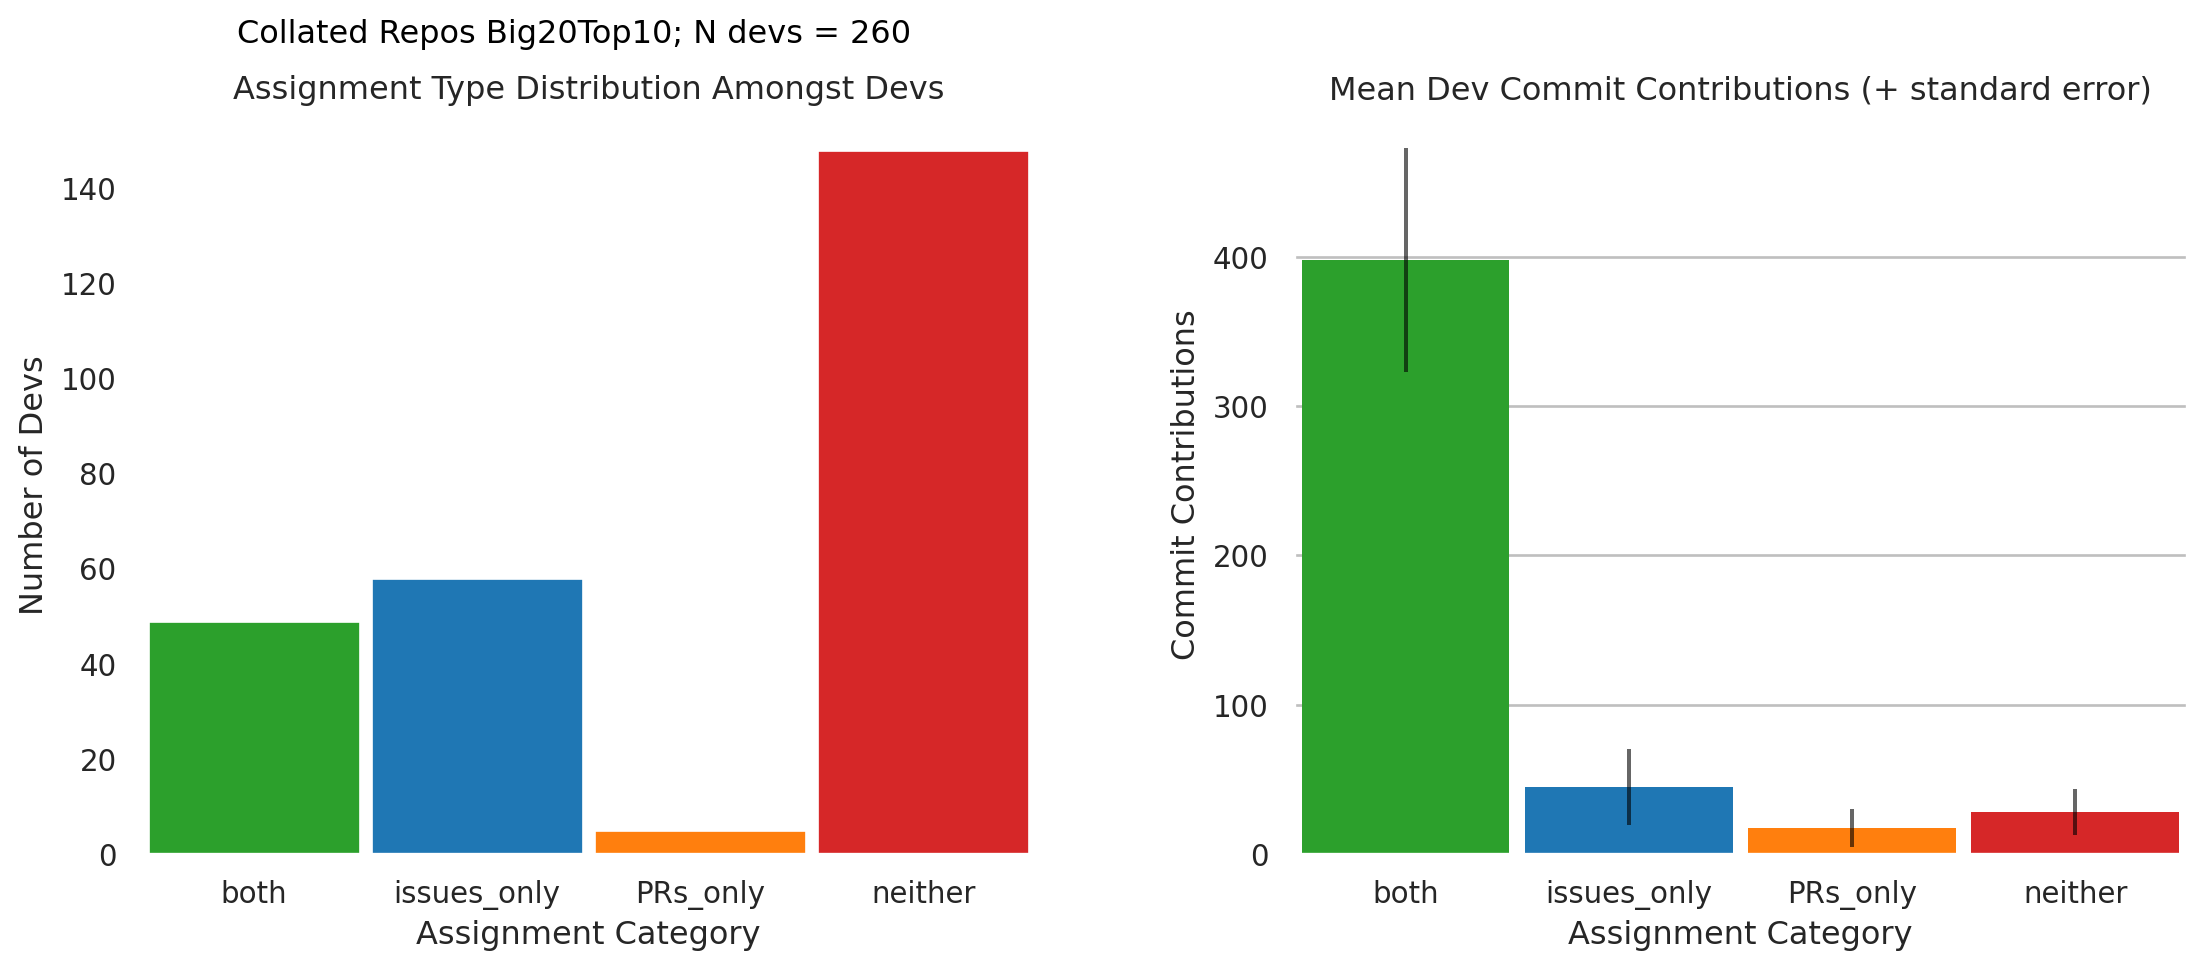

In [19]:
# throw it into the sidebyside plot from before, but working on adding a mean assignments per repo plot in the middle:

# plotting themes/colours setup
cat_order = ['both','issues_only', 'PRs_only', 'neither']
cat_palette = {'both': "#2ca02c", 'issues_only':  "#1f77b4", 'PRs_only': "#ff7f0e", 'neither': "#d62728"}
palette_list = list(cat_palette.values())

f = matplotlib.figure.Figure(figsize=(12, 5))
#sf1, sf2, sf3 = f.subfigures(1,3)
sf1, sf2 = f.subfigures(1,2)
sf1.suptitle(f'Collated Repos Big20Top10; N devs = {len(dev_assignments.dev_name.index)}')
(
    so.Plot(
        data=dev_assignments, 
        x='assignment',
        color='assignment' 
    )
    .add(so.Bars(width=.95, alpha=1), so.Count(), legend=False)
    .scale(x=so.Nominal(order=cat_order), color=so.Nominal(palette_list, order=cat_order), legend=False)
    .label(y='Number of Devs', x='Assignment Category', title="Assignment Type Distribution Amongst Devs", legend=None)
    .theme({"axes.facecolor": "w"})
    .on(sf1)
    .plot()
)
#(
#     so.Plot(
#         data=dev_assignments.groupby(by='repo_name'), 
#         x='assignment', 
#         color='assignment' 
#     )
#     .add(so.Bar(width=.95, alpha=1), so.Agg(), legend=False)
#     .scale(x=so.Nominal(order=cat_order), color=so.Nominal(palette_list, order=cat_order), legend=False)
#     .label(y='Number of Devs', x='Assignment Category', title="Assignment Type Distribution Amongst Devs", legend=None)
#     .theme({"axes.facecolor": "w"})
#     .on(sf2)
#     .plot()
#)
(
    so.Plot(data=dev_assignments, x='assignment', y='contributions', color='assignment')
    .theme({"axes.facecolor": "w", "grid.color":'grey', "grid.alpha": 0.5, "axes.axisbelow":True})
    .add(so.Bar(width=.93, alpha=1), so.Agg('mean'), legend=False)
    .scale(x=so.Nominal(order=cat_order), alpha=1, color=so.Nominal(palette_list, order=cat_order), legend=False)
    .add(so.Range(color='black', alpha=0.6), so.Est(errorbar="se"), legend=None)
    .label(y='Commit Contributions', x='Assignment Category', title="Mean Dev Commit Contributions (+ standard error)")
    .on(sf2)
    .plot()
)

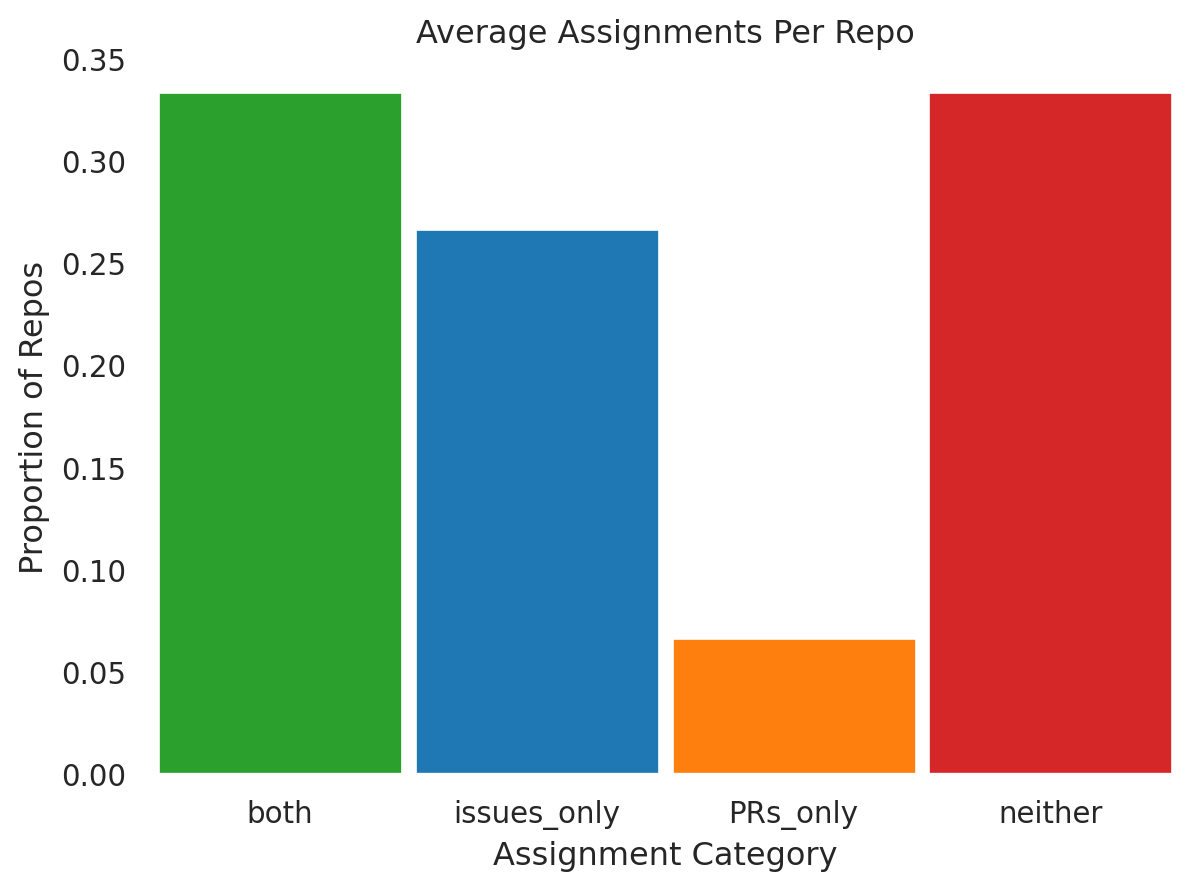

In [36]:
grouped_df = collated_df.groupby(["repo_name", "assignment"], group_keys=True)
grouped_assignments = grouped_df[['assignment']].value_counts(dropna=False)
#repo_name                                                         assignment 
#devs-assignments_Axelrod-Python-Axelrod_2024-03-11.csv            both            3
#                                                                issues_only     5
#                                                                 neither        66
#devs-assignments_CICE-Consortium-CICE_2024-03-11.csv              both            5
#                                                                 issues_only    15
#                                                                  neither         2
#devs-assignments_CICE-Consortium-Icepack_2024-03-11.csv           both            5

counts_assignments = grouped_df[['assignment']].value_counts(dropna=False).reset_index().rename(columns={"index": "value", 0: "count"})

dev_assignments = collated_df

(
    so.Plot(
    data=counts_assignments,
    x='assignment',
    y='count',
    color='assignment' 
    )
    .add(so.Bars(width=.95, alpha=1), so.Hist(stat='proportion'), legend=False)
    .scale(x=so.Nominal(order=cat_order), color=so.Nominal(palette_list, order=cat_order), legend=False)
    .label(y='Proportion of Repos', x='Assignment Category', title="Average Assignments Per Repo", legend=None)
    .theme({"axes.facecolor": "w"})
    .plot()
)

In [87]:
print(dev_assignments)
# save out to file 
dev_assignments.to_csv("../../data/big20top10-dev_assignments_2024-03-11.csv", mode='w', index=True, header=True)

    Unnamed: 0        dev_name  total  PRs  issues           login  type  \
0            0          Chadys    1.0  0.0     1.0          Chadys  User   
1            1     Nikoleta-v3    4.0  1.0     3.0     Nikoleta-v3  User   
2            2   drvinceknight  115.0  8.0   107.0   drvinceknight  User   
3            3     gaffney2010    1.0  0.0     1.0     gaffney2010  User   
4            4      marcharper   28.0  4.0    24.0      marcharper  User   
..         ...             ...    ...  ...     ...             ...   ...   
19          28   apurvvarshney    0.0  0.0     0.0   apurvvarshney  User   
20          29    garethgeorge    0.0  0.0     0.0    garethgeorge  User   
21          30      ascientist    0.0  0.0     0.0      ascientist  User   
22          31  oliver-contier    0.0  0.0     0.0  oliver-contier  User   
23          32       subawocit    0.0  0.0     0.0       subawocit  User   

    contributions  email  name   assignment  \
0            53.0    NaN   NaN  issues_o

In [139]:
dev_assignments['assignment'].value_counts()

neither        148
issues_only     58
both            49
PRs_only         5
Name: assignment, dtype: int64

In [95]:
dev_assignments['type'].describe()

count      246
unique       2
top       User
freq       243
Name: type, dtype: object

In [94]:
dev_assignments['type'].value_counts()

User    243
Bot       3
Name: type, dtype: int64

In [103]:
tmp = dev_assignments.groupby(by='type')

tmp[['type', 'issues', 'PRs', 'total', 'contributions']].max()

,type,issues,PRs,total,contributions
type,,,,,
Bot,Bot,0.0,0.0,0.0,11.0
User,User,175.0,532.0,621.0,2287.0


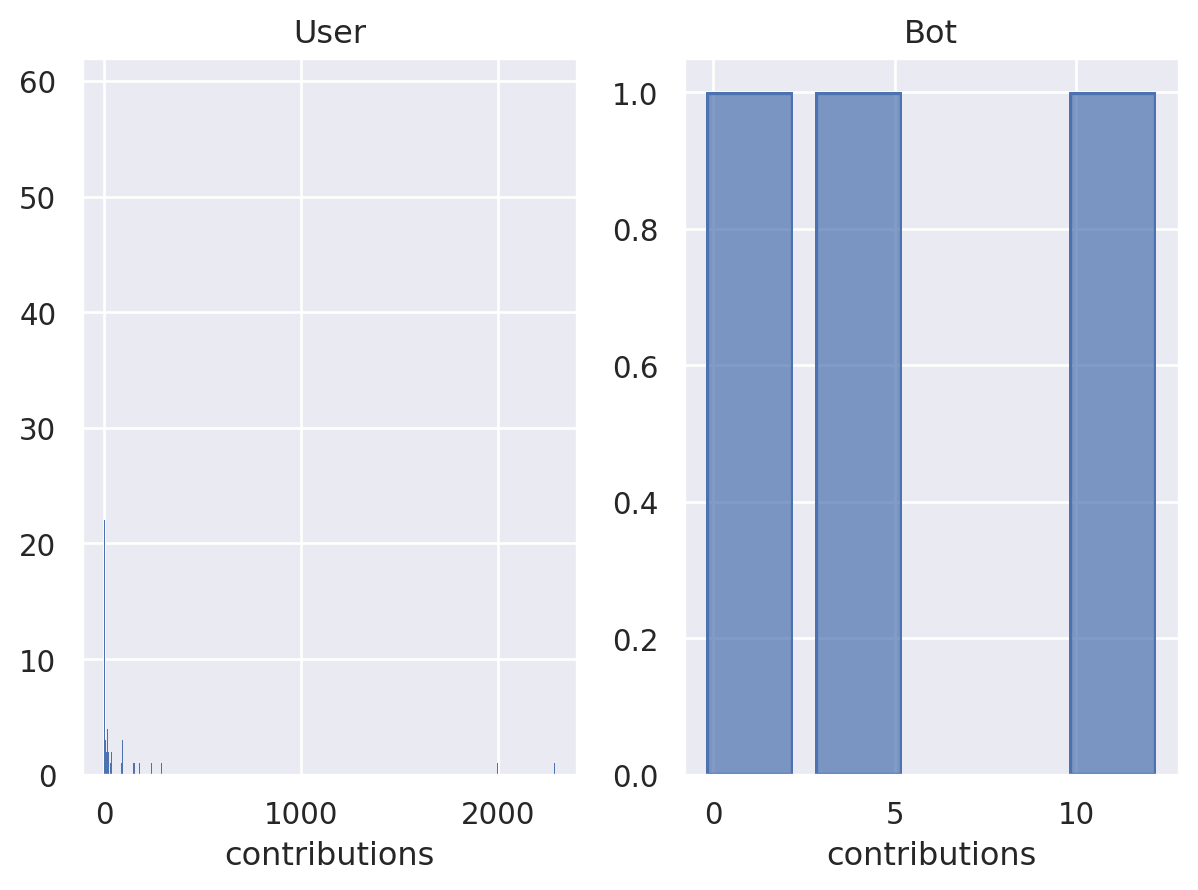

In [104]:
(
    so.Plot(
        data=dev_assignments, 
        x='contributions', 
    )
    .add(so.Bar(), so.Count())
    .facet('type')
    .share(x=False, y=False)
)


In [ ]:
# plot assigned vs unassigned numbers of items 
# plot repos using assignment vs not  
# do time windowing of measures (TODO!)

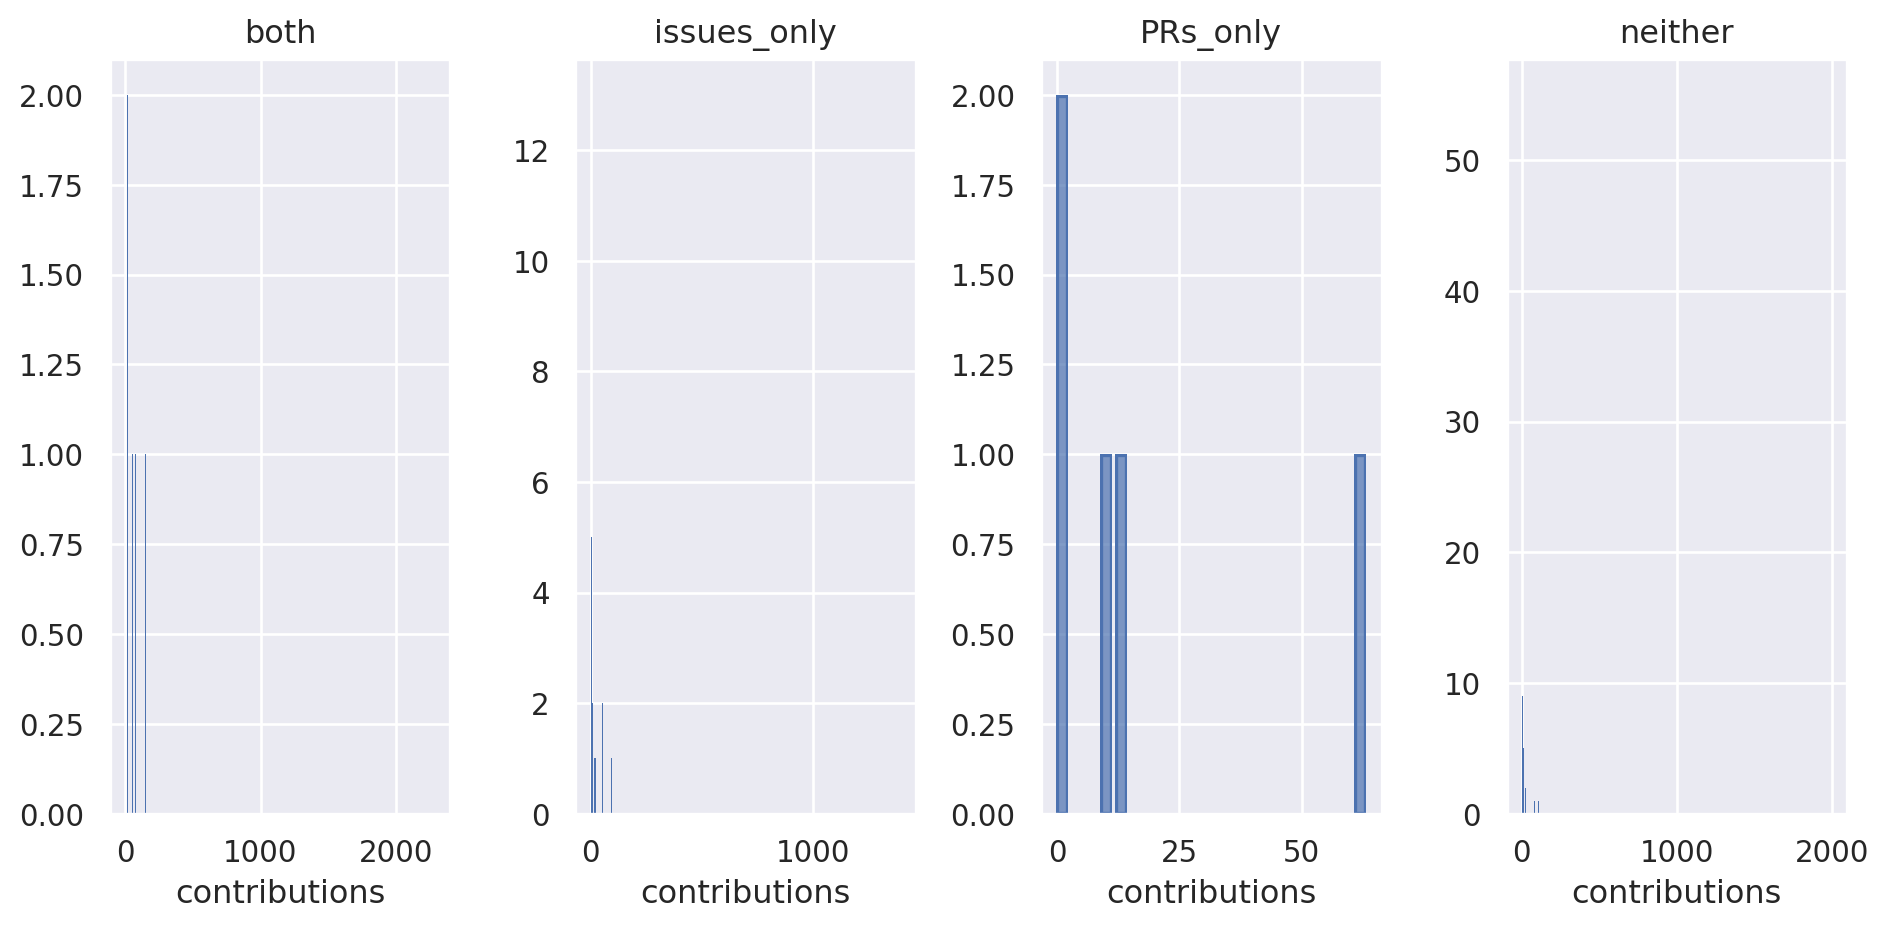

In [73]:
# plot frequency/N Devs (y) vs number of commits (x): facet/colour by assignment maybe? 

(
    so.Plot(
        data=dev_assignments,
        x='contributions'
        #color='assignment' 
    )
    .layout(size=(10,5))
    .add(so.Bar(), so.Count())
    .facet('assignment', order=cat_order)
    .share(x=False, y=False)
)


In [75]:
dev_assignments_issues_only = dev_assignments[dev_assignments['assignment']=='issues_only']
dev_assignments_issues_only.describe()

,Unnamed: 0,total,PRs,issues,contributions,email,name
count,58.000000,58.000000,58.0,58.000000,58.000000,0.0,0.0
mean,7.241379,5.793103,0.0,5.793103,44.827586,NaN,NaN
std,5.436428,9.801107,0.0,9.801107,183.903783,NaN,NaN
min,0.000000,1.000000,0.0,1.000000,0.000000,NaN,NaN
25%,3.000000,1.000000,0.0,1.000000,1.000000,NaN,NaN
50%,6.000000,2.000000,0.0,2.000000,3.000000,NaN,NaN
75%,11.000000,6.000000,0.0,6.000000,20.500000,NaN,NaN
max,20.000000,50.000000,0.0,50.000000,1392.000000,NaN,NaN


In [76]:
dev_assignments_PRs_only = dev_assignments[dev_assignments['assignment']=='PRs_only']
dev_assignments_PRs_only.describe()

,Unnamed: 0,total,PRs,issues,contributions,email,name
count,5.000000,5.000000,5.000000,5.0,5.00000,0.0,0.0
mean,5.400000,1.400000,1.400000,0.0,17.40000,NaN,NaN
std,4.722288,0.894427,0.894427,0.0,25.50098,NaN,NaN
min,0.000000,1.000000,1.000000,0.0,1.00000,NaN,NaN
25%,1.000000,1.000000,1.000000,0.0,1.00000,NaN,NaN
50%,7.000000,1.000000,1.000000,0.0,10.00000,NaN,NaN
75%,8.000000,1.000000,1.000000,0.0,13.00000,NaN,NaN
max,11.000000,3.000000,3.000000,0.0,62.00000,NaN,NaN


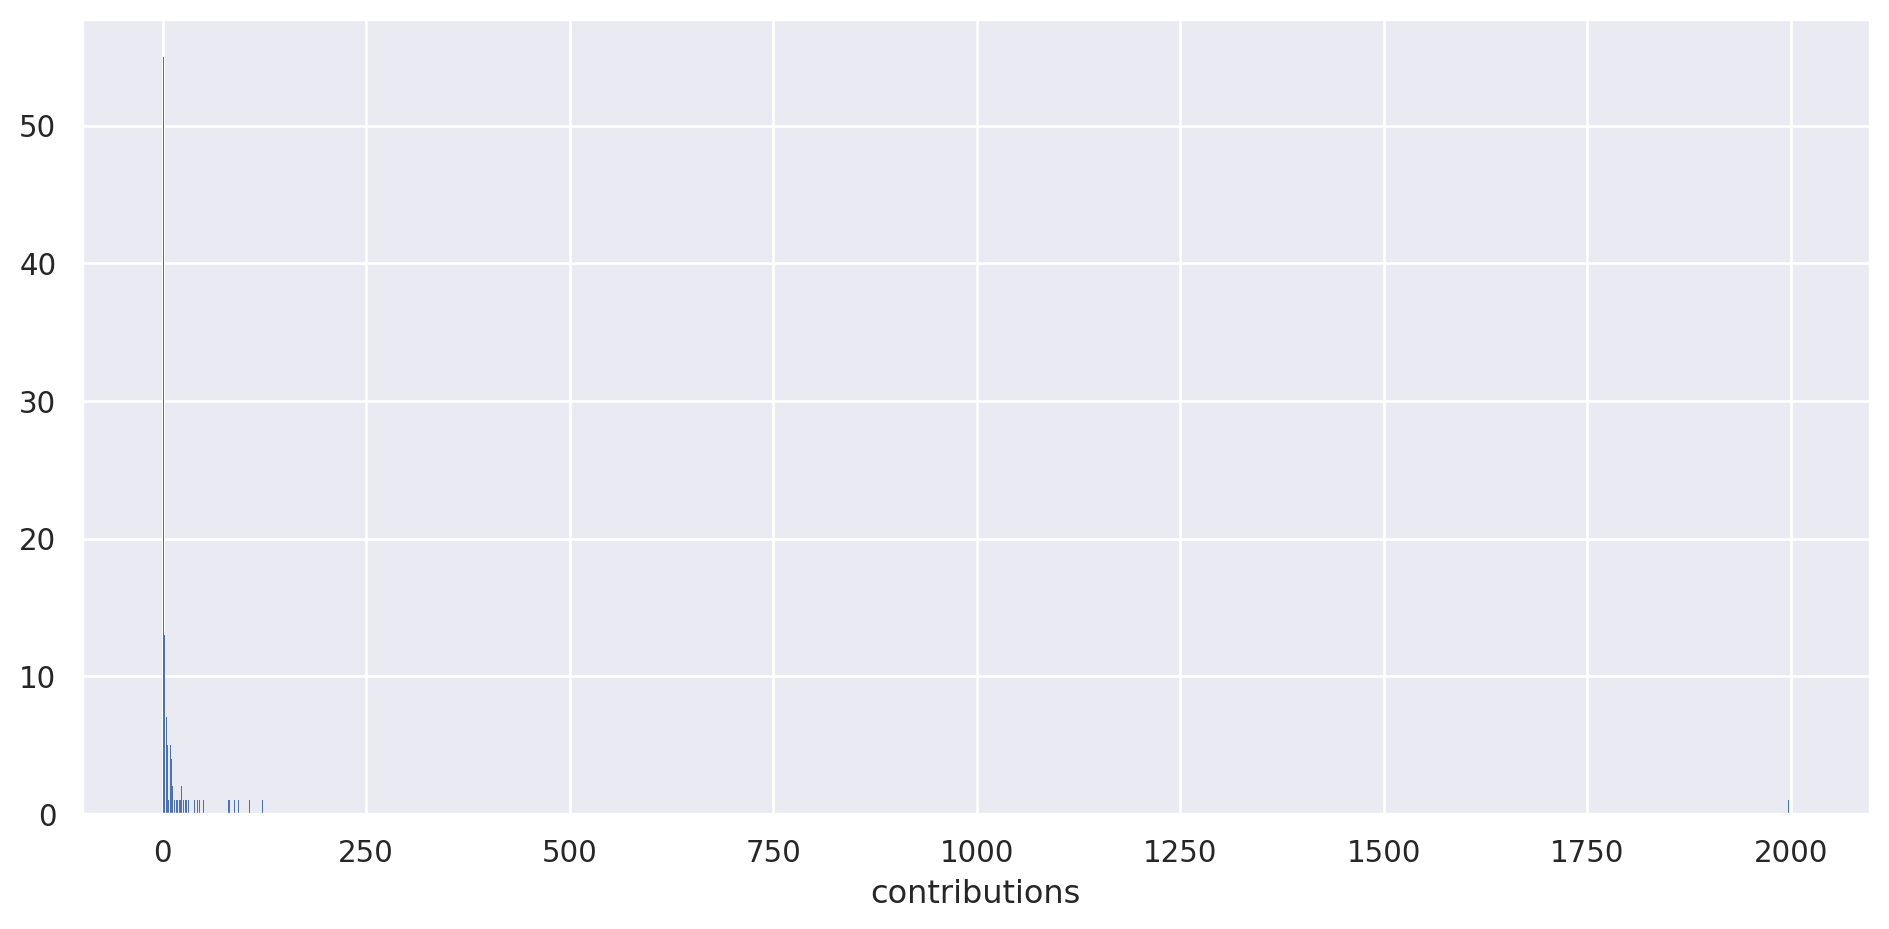

In [55]:
# plot frequency/N Devs (y) vs number of commits (x): facet/colour by assignment maybe? 
dev_assignments_neither = dev_assignments[dev_assignments['assignment']=='neither']

(
    so.Plot(
        data=dev_assignments_neither,
        x='contributions'
        #color='assignment' 
    )
    .layout(size=(10,5))
    .add(so.Bar(), so.Count())
)

In [59]:
dev_assignments_neither.describe()

,Unnamed: 0,total,PRs,issues,contributions,email,name
count,148.000000,148.0,148.0,148.0,148.000000,0.0,0.0
mean,34.641892,0.0,0.0,0.0,28.081081,NaN,NaN
std,20.065542,0.0,0.0,0.0,169.734307,NaN,NaN
min,7.000000,0.0,0.0,0.0,1.000000,NaN,NaN
25%,20.750000,0.0,0.0,0.0,1.000000,NaN,NaN
50%,29.000000,0.0,0.0,0.0,3.000000,NaN,NaN
75%,46.250000,0.0,0.0,0.0,10.000000,NaN,NaN
max,83.000000,0.0,0.0,0.0,1997.000000,NaN,NaN


In [62]:
dev_assignments_neither.sort_values(by=['contributions'], ascending=False)

,Unnamed: 0,dev_name,total,PRs,issues,login,type,contributions,email,name,assignment,repo_name
19,20,pyup-bot,0.0,0.0,0.0,pyup-bot,User,1997.0,NaN,NaN,neither,devs-assignments_Dallinger-Dallinger_2024-03-1...
6,7,tsj5,0.0,0.0,0.0,tsj5,User,520.0,NaN,NaN,neither,devs-assignments_NOAA-GFDL-MDTF-diagnostics_20...
7,8,yihungkuo,0.0,0.0,0.0,yihungkuo,User,138.0,NaN,NaN,neither,devs-assignments_NOAA-GFDL-MDTF-diagnostics_20...
8,9,eric-s-s,0.0,0.0,0.0,eric-s-s,User,123.0,NaN,NaN,neither,devs-assignments_Axelrod-Python-Axelrod_2024-0...
9,10,janga1997,0.0,0.0,0.0,janga1997,User,107.0,NaN,NaN,neither,devs-assignments_Axelrod-Python-Axelrod_2024-0...
...,...,...,...,...,...,...,...,...,...,...,...,...
27,33,cwsmith,0.0,0.0,0.0,cwsmith,User,1.0,NaN,NaN,neither,devs-assignments_MPAS-Dev-compass_2024-03-11.csv
28,34,mattdturner,0.0,0.0,0.0,mattdturner,User,1.0,NaN,NaN,neither,devs-assignments_MPAS-Dev-compass_2024-03-11.csv
29,35,dengwirda,0.0,0.0,0.0,dengwirda,User,1.0,NaN,NaN,neither,devs-assignments_MPAS-Dev-compass_2024-03-11.csv
11,14,cmbitz,0.0,0.0,0.0,cmbitz,User,1.0,NaN,NaN,neither,devs-assignments_NOAA-GFDL-MDTF-diagnostics_20...


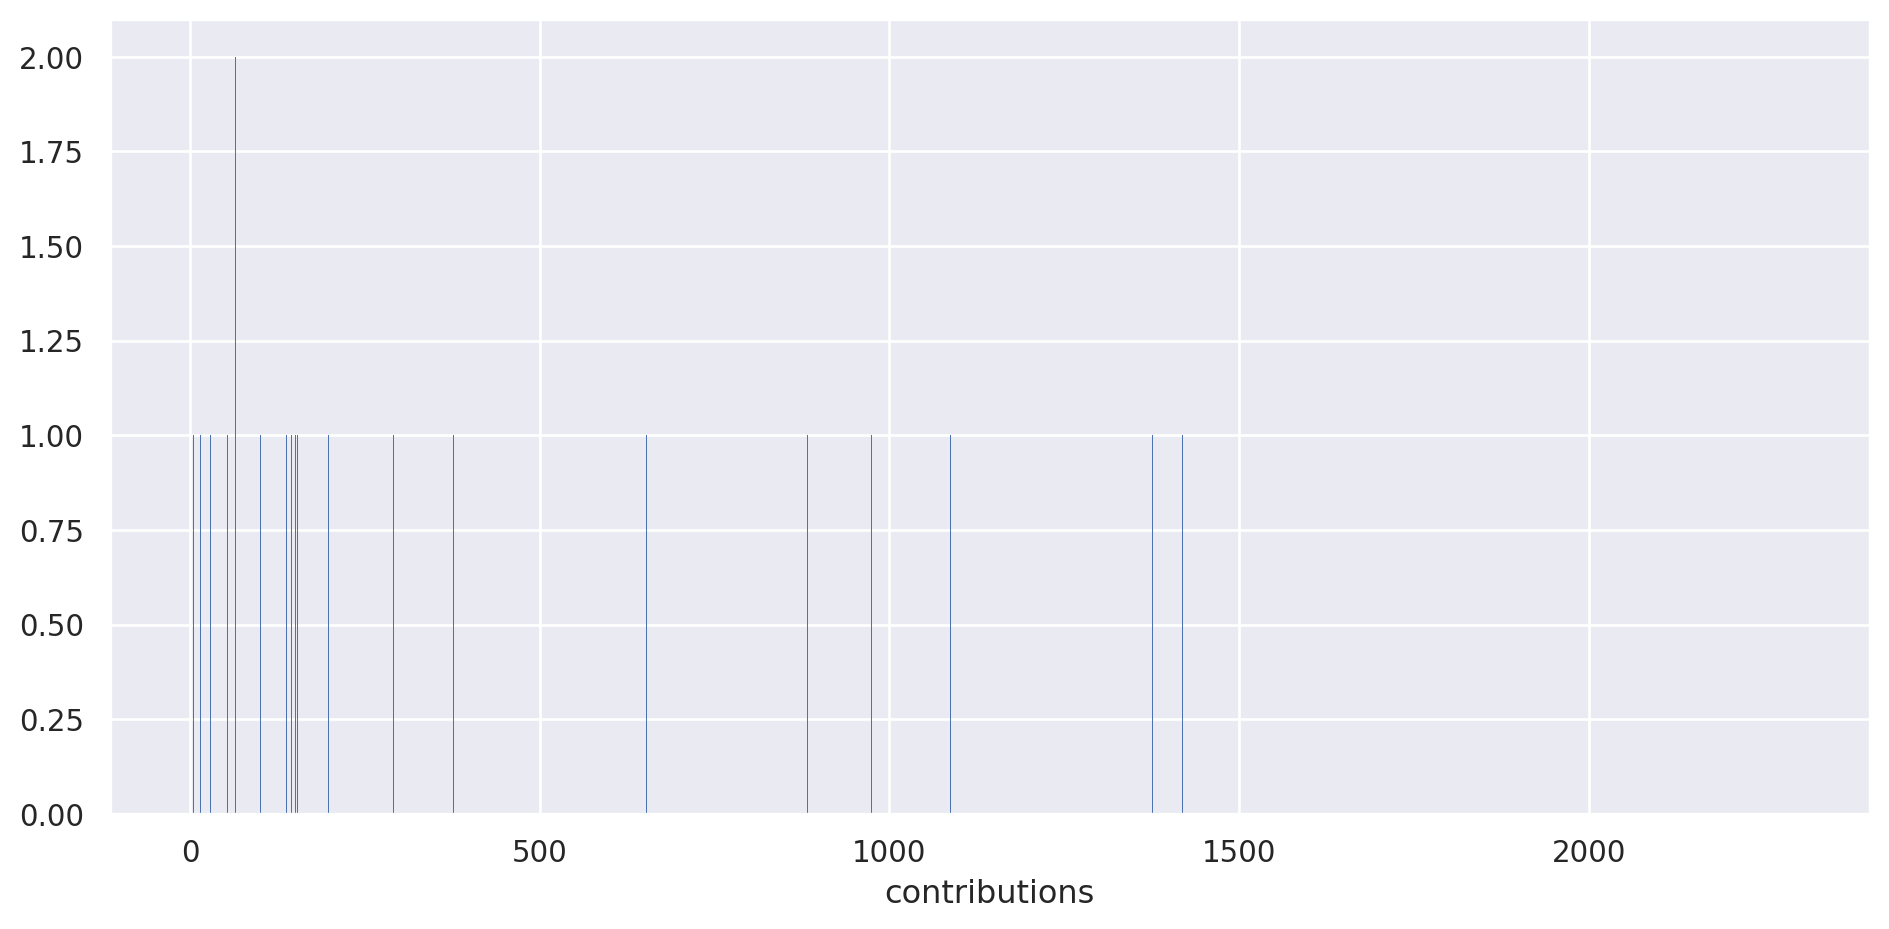

In [78]:
dev_assignments_both = dev_assignments[dev_assignments['assignment']=='both']

(
    so.Plot(
        data=dev_assignments_both,
        x='contributions'
        #color='assignment' 
    )
    .layout(size=(10,5))
    .add(so.Bar(), so.Count())
)

In [67]:
dev_assignments_both.describe()

,Unnamed: 0,total,PRs,issues,contributions,email,name
count,49.000000,49.000000,49.000000,49.000000,49.000000,0.0,0.0
mean,6.408163,68.530612,34.000000,34.530612,398.122449,NaN,NaN
std,5.171711,104.462932,82.545694,37.617096,515.279359,NaN,NaN
min,0.000000,4.000000,1.000000,1.000000,0.000000,NaN,NaN
25%,2.000000,13.000000,2.000000,8.000000,76.000000,NaN,NaN
50%,5.000000,32.000000,8.000000,20.000000,154.000000,NaN,NaN
75%,10.000000,72.000000,24.000000,50.000000,452.000000,NaN,NaN
max,19.000000,621.000000,532.000000,175.000000,2287.000000,NaN,NaN


In [66]:
dev_assignments_both.sort_values(by=['contributions'], ascending=False)

,Unnamed: 0,dev_name,total,PRs,issues,login,type,contributions,email,name,assignment,repo_name
14,15,xylar,621.0,532.0,89.0,xylar,User,2287.0,NaN,NaN,both,devs-assignments_MPAS-Dev-compass_2024-03-11.csv
2,2,drvinceknight,115.0,8.0,107.0,drvinceknight,User,1791.0,NaN,NaN,both,devs-assignments_Axelrod-Python-Axelrod_2024-0...
4,4,tsjackson-noaa,47.0,13.0,34.0,tsjackson-noaa,User,1419.0,NaN,NaN,both,devs-assignments_NOAA-GFDL-MDTF-diagnostics_20...
9,9,jessesnyder,89.0,10.0,79.0,jessesnyder,User,1376.0,NaN,NaN,both,devs-assignments_Dallinger-Dallinger_2024-03-1...
14,14,suchow,32.0,6.0,26.0,suchow,User,1345.0,NaN,NaN,both,devs-assignments_Dallinger-Dallinger_2024-03-1...
6,6,fmhoeger,109.0,76.0,33.0,fmhoeger,User,1087.0,NaN,NaN,both,devs-assignments_Dallinger-Dallinger_2024-03-1...
4,4,marcharper,28.0,4.0,24.0,marcharper,User,974.0,NaN,NaN,both,devs-assignments_Axelrod-Python-Axelrod_2024-0...
1,1,kinverarity1,92.0,10.0,82.0,kinverarity1,User,922.0,NaN,NaN,both,devs-assignments_kinverarity1-lasio_2024-03-11...
0,0,ayllon,66.0,10.0,56.0,ayllon,User,883.0,NaN,NaN,both,devs-assignments_astrorama-SourceXtractorPlusP...
15,15,thomasmorgan,10.0,2.0,8.0,thomasmorgan,User,742.0,NaN,NaN,both,devs-assignments_Dallinger-Dallinger_2024-03-1...


In [47]:
# total number of distinct devs
dev_assignments['dev_name'].nunique()

235

In [49]:
# total number of dev name entries
dev_assignments['dev_name'].count()

260

In [84]:
for name in dev_assignments['dev_name'].sort_values():
    print(name)

314pe
ABarriscale
AdamPohl
CamDavidsonPilon
Chadys
Conrad-Crowley
DallingerBot
DavidCEllis
DeniseWorthen
Dubath
DylanLin29
ElineVG
Epsiilon
FakeNameSE
FrancieNagiki
Fry484
GDKO
GGOUSSEAUD
GNellyEmlaw
HKaras
HKaras
Inviro
JFLemieux73
JFLemieux73
JasYoung315
JustinGOSSES
Jyhess
Karlos78
Luke-Poeppel
MHakem
MXB6669
MandarJKulkarni
MariosZoulias
MatthewWilkes
MichaelWinton
NeuroscienceScripts
Nikoleta-v3
RobPDev
RomeroLaura
TillRasmussen
TillRasmussen
VartanAhrensKayayan
VelizarVESSELINOV
WadeVaresio
Wen-hao-Dong
WonkySpecs
a-paxton
abouchat
adamwulf
ae3e
ahbutlerwx
aiwenxu
akash-suresh
akturner
alcarney
alecpm
alexhroom
alicebarthel
altheaden
amkratz
anders-dc
anders-dc
andrewdnolan
anton-seaice
apcraig
apcraig
apurvvarshney
aradhakrishnanGFDL
architSrivastav
areebahmed04
arokem
ascientist
aseyq
ayllon
ben-harack
bgschaid
bitterbark
bootandy
bradyrx
bricef
buckbaskin
caddycarine
caozd999
cbegeman
ceblanton
cewing
cguardia
chiruzzimarco
chrisknewman
cmbitz
connortann
cwsmith
dabail10
dabai

## Try to subset data within standard deviation of contributions? 

In [108]:
dev_assignments.std(skipna=True, ddof=1, numeric_only=True)

Unnamed: 0        20.768205
total             52.308806
PRs               37.947021
issues            21.340374
contributions    305.930388
email                   NaN
name                    NaN
dtype: float64

In [171]:
grp = dev_assignments.groupby(by=['assignment'])
grp.std(ddof=1, numeric_only=True)

,Unnamed: 0,total,PRs,issues,contributions,email,name
assignment,,,,,,,
PRs_only,4.722288,0.894427,0.894427,0.000000,25.500980,NaN,NaN
both,5.171711,104.462932,82.545694,37.617096,515.279359,NaN,NaN
issues_only,5.436428,9.801107,0.000000,9.801107,183.903783,NaN,NaN
neither,20.065542,0.000000,0.000000,0.000000,169.734307,NaN,NaN


PRs_only            Axes(0.1,0.559091;0.363636x0.340909)
both           Axes(0.536364,0.559091;0.363636x0.340909)
issues_only             Axes(0.1,0.15;0.363636x0.340909)
neither            Axes(0.536364,0.15;0.363636x0.340909)
dtype: object

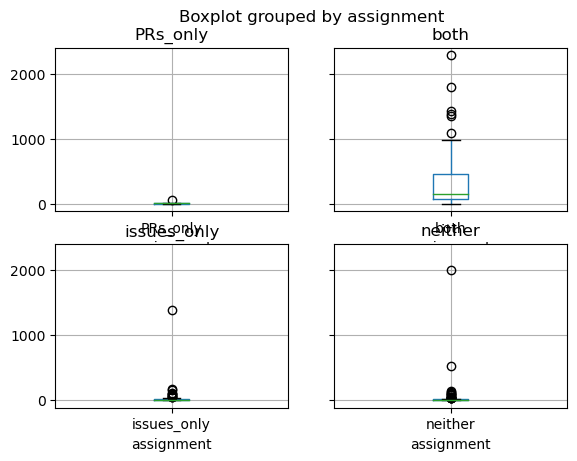

In [169]:
grp.boxplot(column='contributions', by='assignment')

/tmp/ipykernel_245043/2114290744.py:1: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  grp.boxplot(column='total', by='assignment')


PRs_only            Axes(0.1,0.559091;0.363636x0.340909)
both           Axes(0.536364,0.559091;0.363636x0.340909)
issues_only             Axes(0.1,0.15;0.363636x0.340909)
neither            Axes(0.536364,0.15;0.363636x0.340909)
dtype: object

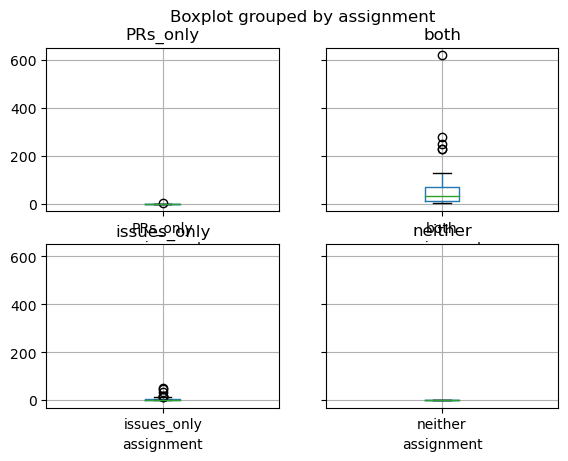

In [172]:
grp.boxplot(column='total', by='assignment')

## Try an ANOVA to check for differences between the assignment groups in contributions 

In [ ]:
# based on the details for scipy stats, ANOVA only works if you satisfy assumptions: 
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html 

#The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid.
  #The samples are independent.
  #Each sample is from a normally distributed population.
  #The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

# So I'd need to ensure that those are true for my data  
# BUT based on above, the standard deviations are not equal for my groups in either total or contributions...

# Can I transform the data to ensure it meets these criteria?
# Alternatively I may need to try the Kruskal-Wallis H test or the AlexanderGovern one 

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html#scipy.stats.kruskal
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.alexandergovern.html#scipy.stats.alexandergovern

In [165]:
import scipy.stats as stats

# TOTES INAPPROPES ANOVA: 

# method via: https://www.geeksforgeeks.org/how-to-perform-a-one-way-anova-in-python/ 

# group data by 'assignment' 
contributions_frame = dev_assignments[['assignment', 'contributions']]

# extract groups 
both = dev_assignments_both['contributions'] 
issues_only = dev_assignments_issues_only['contributions'] 
PRs_only = dev_assignments_PRs_only['contributions'] 
neither = dev_assignments_neither['contributions']  

#print(both)
#print(".....")
#print(neither)

stats.f_oneway(both, issues_only, PRs_only, neither)
#F_onewayResult(statistic=24.055169942343, pvalue=9.530611358655972e-14) # lol 

stats.f_oneway(both, neither)
#F_onewayResult(statistic=57.889273187426795, pvalue=1.1536029211348295e-12) # whelp. D:

F_onewayResult(statistic=57.889273187426795, pvalue=1.1536029211348295e-12)

In [166]:
stats.kruskal(both, neither)
# KruskalResult(statistic=84.06772721806304, pvalue=4.781120466931489e-20)  # Hmmm

KruskalResult(statistic=84.06772721806304, pvalue=4.781120466931489e-20)

ValueError: `popmean.shape[axis]` must equal 1.

## Trying a Tukey Test to compare the pairs of groups for TOTAL ASSIGNMENTS 

Testing assignment groups vs Total items assigned


group1,group2,meandiff,p-adj,lower,upper,reject
PRs_only,both,67.1306,0.01,11.9277,122.3335,True
PRs_only,issues_only,4.3931,0.9968,-50.4118,59.198,False
PRs_only,neither,-1.4,0.9999,-54.8661,52.0661,False
both,issues_only,-62.7375,0.0,-85.5529,-39.9221,True
both,neither,-68.5306,0.0,-87.9106,-49.1507,True
issues_only,neither,-5.7931,0.8438,-24.0084,12.4222,False


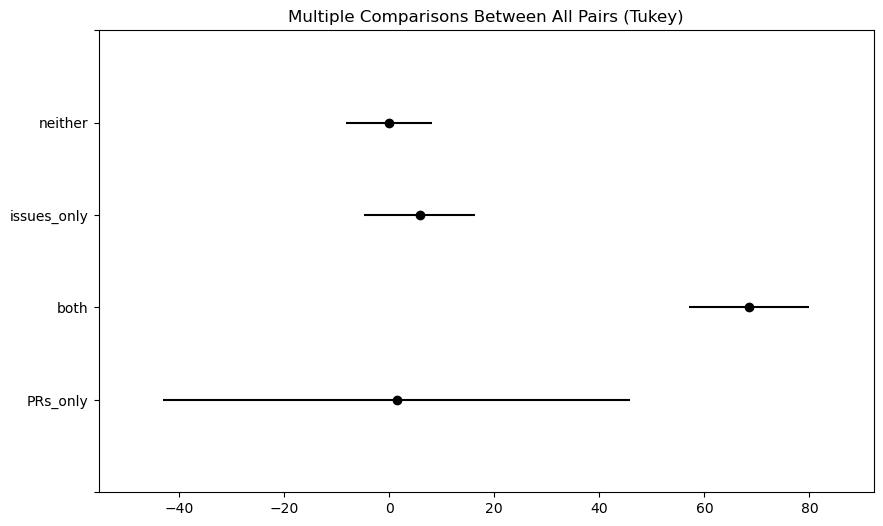

In [163]:
totals = dev_assignments.total
#totals

assignments = dev_assignments.assignment
#assignments

from statsmodels.stats.multicomp import pairwise_tukeyhsd

print("Testing assignment groups vs Total items assigned")

tukey_total = pairwise_tukeyhsd(endog=totals, groups=assignments, alpha=0.05)

tukey_total.plot_simultaneous()

tukey_total.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
PRs_only,both,380.7224,0.0164,50.759,710.6859,True
PRs_only,issues_only,27.4276,0.9964,-300.1569,355.012,False
PRs_only,neither,10.6811,0.9998,-308.9006,330.2628,False
both,issues_only,-353.2949,0.0,-489.669,-216.9208,True
both,neither,-370.0414,0.0,-485.8808,-254.202,True
issues_only,neither,-16.7465,0.9786,-125.6247,92.1317,False


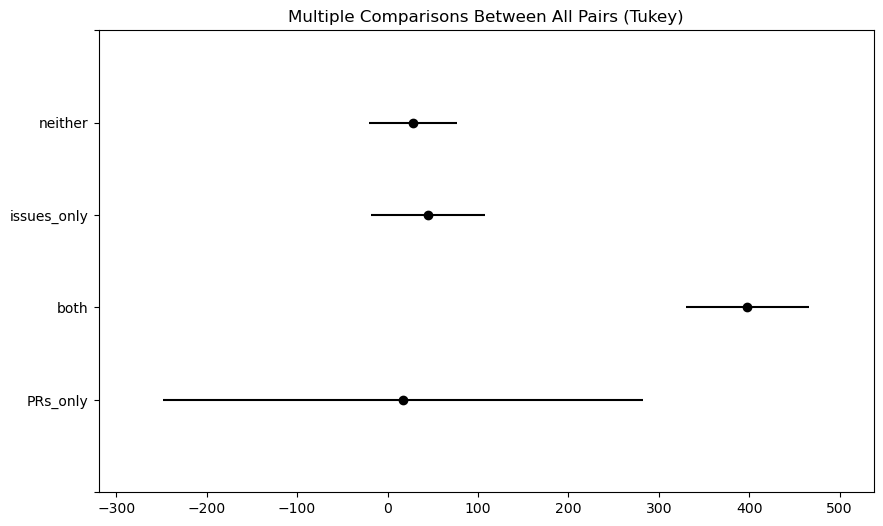

In [162]:
contributionses = dev_assignments.contributions
#contributionses

#print("Testing assignment groups vs commit contributions")
tukey_contribs = pairwise_tukeyhsd(endog=contributionses, groups=assignments, alpha=0.05)

tukey_contribs.plot_simultaneous()

tukey_contribs.summary()

### There are devs in multiple repos here.  

## 1 Repo Version of Poster Plot

In [5]:
#repo_name = 'MotionbyLearning/stm' # 61
#repo_name = 'JeschkeLab/DeerLab'
repo_name = 'Axelrod-Python/Axelrod'

import githubanalysis.processing.get_all_pages_issues
from githubanalysis.processing.get_all_pages_issues import IssueGetter

logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='../../logs/get_all_pages_issues_NOTEBOOK_logs.txt')  
issues_getter = IssueGetter(logger)

iss_df = issues_getter.get_all_pages_issues(repo_name=repo_name, config_path='../../githubanalysis/config.cfg', out_filename='all-issues', write_out_location='../../data/')

INFO:>> Running issue grab for repo JeschkeLab/DeerLab, in page 1 of 5.
INFO:>> Running issue grab for repo JeschkeLab/DeerLab, in page 2 of 5.
INFO:>> Running issue grab for repo JeschkeLab/DeerLab, in page 3 of 5.
INFO:>> Running issue grab for repo JeschkeLab/DeerLab, in page 4 of 5.
INFO:>> Running issue grab for repo JeschkeLab/DeerLab, in page 5 of 5.


In [6]:
import githubanalysis.processing.get_repo_contributors
from githubanalysis.processing.get_repo_contributors import DevsGetter

logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='../../logs/get_repo_contributors_NOTEBOOK_logs.txt')  
devs_getter = DevsGetter(logger)

devs_df = devs_getter.get_repo_contributors(repo_name=repo_name, config_path='../../githubanalysis/config.cfg', out_filename='contributors', write_out_location='../../data/')

INFO:Total number of contributors grabbed is 7 in 1 page(s).
INFO:There are 1 anonymous contributors for repo JeschkeLab/DeerLab.


Text(0.5, 1.0, 'Assignment Types amongst (non-Anonymous) Developers in JeschkeLab/DeerLab repo')

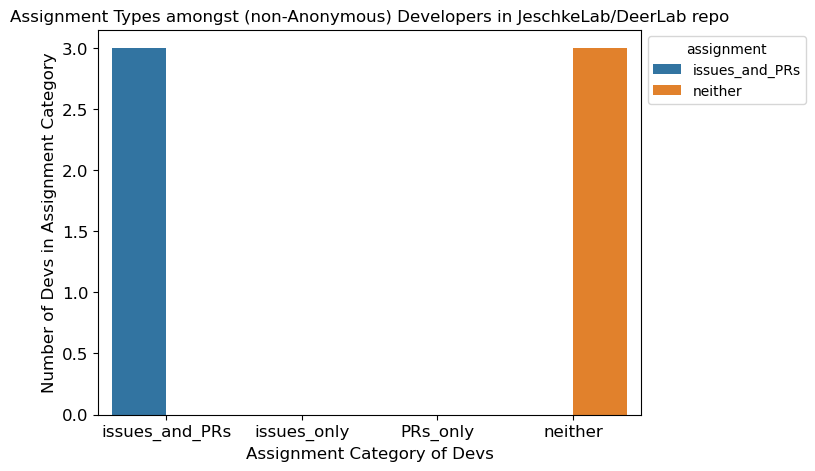

In [7]:
from ast import literal_eval

repo_name = 'JeschkeLab/DeerLab'
issues_data = '../../data/all-issues_JeschkeLab-DeerLab_2024-03-11.csv'
contributors_file = "../../data/contributors_JeschkeLab-DeerLab_2024-03-11.csv"

# read in dataset, explode to deal with multiple assignments on same item  
issues_df = pd.read_csv(issues_data, header=0) 

exploded_devs = pd.DataFrame()
exploded_devs = issues_df

exploded_devs['assigned_devs'] = issues_df['assigned_devs'].apply(literal_eval)
exploded_devs = exploded_devs.explode(column='assigned_devs')
exploded_devs['assigned_devs'] = exploded_devs['assigned_devs'].fillna('unassigned') 

# group by dev
grouped = exploded_devs.groupby('assigned_devs')

all_devs = []
dev_dict = {}

for name, group in grouped:
    total_recs = group['id'].count()
    total_PRs = group['is_PR'].sum()
    dev_dict.update({'dev_name': name})
    dev_dict.update({'total': total_recs})
    dev_dict.update({'PRs': total_PRs})
    dev_dict.update({'issues': total_recs - total_PRs})
    
    #print(dev_dict)
    all_devs.append(dev_dict)
    dev_dict = {}

all_devs_df = pd.DataFrame.from_dict(all_devs)

# read in contributors data and rename 'login' field as 'dev_name' as later joining key  
contributors_df = pd.read_csv(contributors_file, header=0)
contributors_df['dev_name'] = contributors_df['login']

# do outer join on both issues and contributors datasets on dev_name column (full outer join so we don't lose any devs not in other df)    
joinage = pd.merge(all_devs_df, contributors_df, how='outer', on=['dev_name'])

# drop extra columns brought in from contributors dataset  
joinage = joinage[['dev_name', 'total', 'PRs', 'issues', 'login', 'type', 'contributions', 'email', 'name']]

# fill columns from all_devs_df with 0s for newly added devs w/o assignments info from other table    
joinage['total'] = joinage['total'].fillna(value=0)
joinage['PRs'] = joinage['PRs'].fillna(value=0)
joinage['issues'] = joinage['issues'].fillna(value=0)

# assign category based on thresholds of >1 of both, either or none. 
conditions = [
    (joinage['PRs'] > 1) & (joinage['issues'] > 1),
    (joinage['PRs'] == 0) & (joinage['issues'] > 1),
    (joinage['PRs'] > 1) & (joinage['issues'] == 0),
    (joinage['PRs'] == 0) & (joinage['issues'] == 0)
]
choices = ['issues_and_PRs','issues_only', 'PRs_only', 'neither']
joinage['assignment'] = np.select(conditions, choices, default='error')

# remove non-named-dev entries from joined dataset  
joinage = joinage.drop(joinage[joinage['dev_name'] == 'unassigned'].index)
joinage = joinage.drop(joinage[joinage['dev_name'].isna()].index)

#  | dev_name | total | PRs | issues | assignment | login | type | contributions | email | name
# -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | --
# HKaras | 22.0 | 12.0 | 10.0 | issues_and_PRs | HKaras | User | 17.0 | NaN | NaN
# luisfabib | 115.0 | 67.0 | 48.0 | issues_and_PRs | luisfabib | User | 382.0 | NaN | NaN
# stestoll | 16.0 | 14.0 | 2.0 | issues_and_PRs | stestoll | User | 65.0 | NaN | NaN
# mtessmer | 0.0 | 0.0 | 0.0 | neither | mtessmer | User | 14.0 | NaN | NaN
# laenan8466 | 0.0 | 0.0 | 0.0 | neither | laenan8466 | User | 1.0 | NaN | NaN
# edmundxcvi | 0.0 | 0.0 | 0.0 | neither | edmundxcvi | User | 1.0 | NaN | NaN

# make assignment a category datatype
joinage['assignment'] = joinage['assignment'].astype('category')
# set the other categories so whole set is there if not present from data  
joinage['assignment'].cat.set_categories(['issues_and_PRs','issues_only', 'PRs_only', 'neither'])

# plot this repo's categories  
cat_order = ['issues_and_PRs','issues_only', 'PRs_only', 'neither']
plt.figure(figsize=(7,5))
ax=sns.countplot(
    data=joinage, 
    x='assignment', 
    hue='assignment',
    order = cat_order  # show all assignment categories, not just present
)
plt.xticks(size=12)
plt.xlabel('Assignment Category of Devs', size=12)
plt.yticks(size=12)
plt.ylabel('Number of Devs in Assignment Category', size=12)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title(f"Assignment Types amongst (non-Anonymous) Developers in {repo_name} repo")

In [ ]:
# Bigger Different Repo: 

from ast import literal_eval

repo_name = 'Dallinger/Dallinger'
issues_data = '../../data/all-issues_Dallinger-Dallinger_2024-02-27.csv'
contributors_file = "../../data/contributors_Dallinger-Dallinger_2024-02-27.csv"

# read in dataset, explode to deal with multiple assignments on same item  
issues_df = pd.read_csv(issues_data, header=0) 

exploded_devs = pd.DataFrame()
exploded_devs = issues_df

exploded_devs['assigned_devs'] = issues_df['assigned_devs'].apply(literal_eval)
exploded_devs = exploded_devs.explode(column='assigned_devs')
exploded_devs['assigned_devs'] = exploded_devs['assigned_devs'].fillna('unassigned') 

# group by dev
grouped = exploded_devs.groupby('assigned_devs')

all_devs = []
dev_dict = {}

for name, group in grouped:
    total_recs = group['id'].count()
    total_PRs = group['is_PR'].sum()
    dev_dict.update({'dev_name': name})
    dev_dict.update({'total': total_recs})
    dev_dict.update({'PRs': total_PRs})
    dev_dict.update({'issues': total_recs - total_PRs})
    
    #print(dev_dict)
    all_devs.append(dev_dict)
    dev_dict = {}

all_devs_df = pd.DataFrame.from_dict(all_devs)

# read in contributors data and rename 'login' field as 'dev_name' as later joining key  
contributors_df = pd.read_csv(contributors_file, header=0)
contributors_df['dev_name'] = contributors_df['login']

# do outer join on both issues and contributors datasets on dev_name column (full outer join so we don't lose any devs not in other df)    
joinage = pd.merge(all_devs_df, contributors_df, how='outer', on=['dev_name'])

# drop extra columns brought in from contributors dataset  
joinage = joinage[['dev_name', 'total', 'PRs', 'issues', 'login', 'type', 'contributions', 'email', 'name']]

# fill columns from all_devs_df with 0s for newly added devs w/o assignments info from other table    
joinage['total'] = joinage['total'].fillna(value=0)
joinage['PRs'] = joinage['PRs'].fillna(value=0)
joinage['issues'] = joinage['issues'].fillna(value=0)

# assign category based on thresholds of >1 of both, either or none. 
conditions = [
    (joinage['PRs'] >= 1) & (joinage['issues'] >= 1),
    (joinage['PRs'] == 0) & (joinage['issues'] >=1),
    (joinage['PRs'] >=1) & (joinage['issues'] == 0),
    (joinage['PRs'] == 0) & (joinage['issues'] == 0)
]
choices = ['issues_and_PRs','issues_only', 'PRs_only', 'neither']
joinage['assignment'] = np.select(conditions, choices, default='error')

# remove non-named-dev entries from joined dataset  
joinage = joinage.drop(joinage[joinage['dev_name'] == 'unassigned'].index)
joinage = joinage.drop(joinage[joinage['dev_name'].isna()].index)

# make assignment a category datatype
joinage['assignment'] = joinage['assignment'].astype('category')
# set the other categories so whole set is there if not present from data  
joinage['assignment'].cat.set_categories(['issues_and_PRs','issues_only', 'PRs_only', 'neither'])

# plot this repo's categories  
cat_order = ['issues_and_PRs','issues_only', 'PRs_only', 'neither']
plt.figure(figsize=(7,5))
ax=sns.countplot(
    data=joinage, 
    x='assignment', 
    hue='assignment',
    order = cat_order  # show all assignment categories, not just present
)
plt.xticks(size=12)
plt.xlabel('Assignment Category of Devs', size=12)
plt.yticks(size=12)
plt.ylabel('Number of Devs in Assignment Category', size=12)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title(f"Assignment Types amongst (non-Anonymous) Developers in {repo_name} repo")

print(joinage)

current_date_info = datetime.now().strftime("%Y-%m-%d") # run this at start of script not in loop to avoid midnight/long-run issues
sanitised_repo_name = repo_name.replace("/", "-")
write_out = f'../../data/all-devs-assigned_{sanitised_repo_name}'
write_out_extra_info = f"{write_out}_{current_date_info}.csv" 

joinage.to_csv(write_out_extra_info, mode='w', index=True, header=True)

In [ ]:
joinage['assignment'].value_counts()

In [ ]:
joinage['assignment'].value_counts()['issues_only']

In [ ]:
repo_name = 'JeschkeLab/DeerLab'
issues_data = '../../data/all-issues_JeschkeLab-DeerLab_2024-02-22.csv'

issues_df = pd.read_csv(issues_data, header=0) 

print(issues_df.shape)
print(len(issues_df.index))
print(issues_df[issues_df.index==60])

In [ ]:
# reshape dataset to make taller on 'assigned_devs' column (ie 1x row:[dev1, dev2]; -> 2x rows: dev1; dev2

from ast import literal_eval

exploded_devs = pd.DataFrame()
exploded_devs = issues_df

exploded_devs['assigned_devs'] = issues_df['assigned_devs'].apply(literal_eval)
exploded_devs = exploded_devs.explode(column='assigned_devs')
exploded_devs['assigned_devs'] = exploded_devs['assigned_devs'].fillna('unassigned')  

print(exploded_devs.shape)
print(len(exploded_devs.index))
print(exploded_devs[exploded_devs.index==60])

In [ ]:
# this works now due to the literal_eval apply via SO: https://stackoverflow.com/a/63589387 
exploded_devs['assigned_devs'].value_counts(dropna=False)

In [ ]:
# corroboration of those assignments
exploded_devs.groupby('assigned_devs').count()

In [ ]:
grouped = exploded_devs.groupby('assigned_devs')

for name, group in grouped:  # via https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#iterating-through-groups
    print(f"Dev: {name}")
    total_recs = group['id'].count()
    total_PRs = group['is_PR'].sum()
    print(f"  Total assignments: {total_recs}") # using ID since it's guaranteed to be filled 
    print(f"  PRs: {total_PRs}")
    print(f"  Issues: {total_recs - total_PRs}")

In [ ]:
dev_dict = {}

dev_dict.update({'dev_name': name})
dev_dict.update({'total': total_recs})
dev_dict.update({'PRs': total_PRs})
dev_dict.update({'issues': total_recs - total_PRs})

print(dev_dict)

In [ ]:
all_devs = []
dev_dict = {}

for name, group in grouped:
    total_recs = group['id'].count()
    total_PRs = group['is_PR'].sum()
    dev_dict.update({'dev_name': name})
    dev_dict.update({'total': total_recs})
    dev_dict.update({'PRs': total_PRs})
    dev_dict.update({'issues': total_recs - total_PRs})
    
    print(dev_dict)
    all_devs.append(dev_dict)
    dev_dict = {}
    
print(all_devs)

all_devs_df = pd.DataFrame.from_dict(all_devs)
print(all_devs_df.shape)
print(all_devs_df)

In [ ]:
# assign category based on thresholds of >1 of both, either or none. 
conditions = [
    (all_devs_df['PRs'] > 1) & (all_devs_df['issues'] > 1),
    (all_devs_df['PRs'] == 0) & (all_devs_df['issues'] > 1),
    (all_devs_df['PRs'] > 1) & (all_devs_df['issues'] == 0),
    (all_devs_df['PRs'] == 0) & (all_devs_df['issues'] == 0)
]
choices = ['issues_and_PRs','issues_only', 'PRs_only', 'neither']
all_devs_df['assignment'] = np.select(conditions, choices, default='error')
print(all_devs_df)

# method via https://stackoverflow.com/a/19913845 

In [ ]:
all_devs_df

In [ ]:
all_devs_df_melt = pd.melt(all_devs_df, id_vars=['dev_name', 'assignment'], var_name='assigned_to', value_vars=['issues', 'PRs'], value_name='assignment_counts')
all_devs_df_melt

In [ ]:
plt.figure(figsize=(7,5))
ax=sns.catplot(
    data=all_devs_df_melt, 
    x='dev_name',
    y='assignment_counts',
    hue='assigned_to', 
    kind='bar',
    order = exploded_devs['assigned_devs'].value_counts(dropna=False).index
)
all_tix=all_devs_df_melt.assignment_counts.sum()
plt.xticks(size=12)
plt.xlabel('Assigned To Dev', size=12)
plt.yticks(size=12)
plt.ylabel('Count of Tickets/PRs Assigned to Dev', size=12)
plt.title(f"Issue Ticket and Pull Request Assignment amongst Developers in {repo_name} repo:  N = {all_tix}")

In [ ]:
all_devs_df['assignment'] = all_devs_df['assignment'].astype('category')

all_devs_df.dtypes


In [ ]:
all_devs_df['assignment'].cat.set_categories(['issues_and_PRs','issues_only', 'PRs_only', 'neither'])

In [ ]:
# make assignment a category datatype
all_devs_df['assignment'] = all_devs_df['assignment'].astype('category')
# set the other categories so whole set is there if not present from data  
all_devs_df['assignment'].cat.set_categories(['issues_and_PRs','issues_only', 'PRs_only', 'neither'])

# plot this repo's categories  
cat_order = ['issues_and_PRs','issues_only', 'PRs_only', 'neither']
plt.figure(figsize=(7,5))
ax=sns.countplot(
    data=all_devs_df, 
    x='assignment', 
    hue='assignment',
    order = cat_order  # show all assignment categories, not just present
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title(f"Assignment Types amongst Developers in {repo_name} repo")

## TODO:  
  # remove 'unassigned' from the counts for this plot  
  # see if it works for repos with differing assignments  
  # add non-assigned devs from 'contributors' data  
  # create a specific colour palette for issues (blue), PRs (orange), issues & PRs (?both?), and neither (grey?)    



In [ ]:
# read in contributors data: 
contributors_file = "../../data/contributors_JeschkeLab-DeerLab_2024-02-27.csv"

contributors_df = pd.read_csv(contributors_file, header=0)
contributors_df

In [ ]:
for dev in contributors_df['login']: 
    print(all_devs_df['dev_name'].str.contains(str(dev), regex=False))
    

In [ ]:
for dev in all_devs_df['dev_name']:
    print(dev)

In [ ]:
type(contributors_df['login'])

In [ ]:
contributors_df['login'].str.contains('HKaras')

In [ ]:
all_devs_df['dev_name']

In [ ]:
contributors_df['dev_name'] = contributors_df['login']
contributors_df

In [ ]:
joinage = pd.merge(all_devs_df, contributors_df, how='outer', on=['dev_name'])

joinage = joinage[['dev_name', 'total', 'PRs', 'issues', 'assignment', 'login', 'type', 'contributions', 'email', 'name']]

In [ ]:
joinage['total'] = joinage['total'].fillna(value=0)
joinage['PRs'] = joinage['PRs'].fillna(value=0)
joinage['issues'] = joinage['issues'].fillna(value=0)
#joinage['dev_name'] = joinage['dev_name'].fillna(value='Anonymous')

#print(joinage)

# assign category based on thresholds of >1 of both, either or none. 
conditions = [
    (joinage['PRs'] > 1) & (joinage['issues'] > 1),
    (joinage['PRs'] == 0) & (joinage['issues'] > 1),
    (joinage['PRs'] > 1) & (joinage['issues'] == 0),
    (joinage['PRs'] == 0) & (joinage['issues'] == 0)
]
choices = ['issues_and_PRs','issues_only', 'PRs_only', 'neither']
joinage['assignment'] = np.select(conditions, choices, default='error')

print(joinage)


In [ ]:
joinage.dtypes

In [ ]:
joinage = joinage.drop(joinage[joinage['dev_name'] == 'unassigned'].index)
joinage = joinage.drop(joinage[joinage['dev_name'].isna()].index)

joinage

In [ ]:
# make assignment a category datatype
joinage['assignment'] = joinage['assignment'].astype('category')
# set the other categories so whole set is there if not present from data  
joinage['assignment'].cat.set_categories(['issues_and_PRs','issues_only', 'PRs_only', 'neither'])

# plot this repo's categories  
cat_order = ['issues_and_PRs','issues_only', 'PRs_only', 'neither']
plt.figure(figsize=(7,5))
ax=sns.countplot(
    data=joinage, 
    x='assignment', 
    hue='assignment',
    order = cat_order  # show all assignment categories, not just present
)
plt.xticks(size=12)
plt.xlabel('Assignment Category of Devs', size=12)
plt.yticks(size=12)
plt.ylabel('Number of Devs in Assignment Category', size=12)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title(f"Assignment Types amongst (non-Anonymous) Developers in {repo_name} repo")


In [ ]:
plt.figure(figsize=(7,5))
ax=sns.countplot(
    x='assignment', 
    hue='value',
    data=pd.melt(joinage) 
    #order = exploded_devs['assigned_devs'].value_counts(dropna=False).index  # order the bars; via https://stackoverflow.com/a/46624802
)
# plt.xticks(size=12)
# plt.xlabel('Assigned To User', size=12)
# plt.yticks(size=12)
# plt.ylabel('Count of Tickets Assigned', size=12)
# #plt.axhline(y=(all_tix*0.10), linestyle='--', color='black', label=f'25% ({total_assigned}) assigned issues')  # plot line at 10% of all assigned tickets
# plt.title(f"Issue Ticket Assignment in {repo_name} repo:  N = {all_tix}")

In [ ]:
this['assigned_devs'].value_counts(dropna=False)

In [ ]:
# number of PRs assigned to each dev
exploded_devs.groupby('assigned_devs')['is_PR'].sum()

In [ ]:
exploded_devs.groupby('assigned_devs').count() 

In [ ]:
iss_df.dtypes

In [ ]:
print(iss_df)

In [ ]:
iss_df.state.value_counts().open

In [ ]:
print(f"issue state counts: {iss_df.state.value_counts()}")

In [ ]:
print(iss_df['pull_request'])

In [ ]:
iss_df['pull_request'].isna()

In [ ]:
#iss_df['is_PR'] = iss_df['pull_request'].notna()
iss_df['is_PR'].value_counts()

In [ ]:
iss_df['is_PR'].value_counts()[True]

In [ ]:
iss_df

In [ ]:
iss_df[''] = 

In [ ]:
iss_devs = get_assignee.get_issue_assignees(iss_df)

In [ ]:
iss_devs.assigned_devs.value_counts()

In [ ]:
# reshape dataset to make taller on 'assigned_devs' column (ie 1x row:[dev1, dev2]; -> 2x rows: dev1; dev2
exploded_devs = iss_devs.apply(pd.Series).explode(column='assigned_devs', ignore_index=True)

In [ ]:
exploded_devs.assigned_devs.value_counts(normalize=True, dropna=False)

In [ ]:
# calculate 25% of assigned tickets
all_tix = len(iss_devs.index)
total_assigned = len(iss_devs[[bool(x) for x in iss_devs.assigned_devs]])
#non_assigned = all_tix - total_assigned
non_assigned_text = f'{all_tix - total_assigned} Unassigned tickets (N = {all_tix})'

print(exploded_devs['assigned_devs'].value_counts(dropna=False))  # print per-dev assignment counts

# do actual plotting:
exploded_devs['assigned_devs'].value_counts(normalize=True, dropna=False).plot.bar(column='assigned_devs', color='red', label='assigned tickets')

plt.xlabel("Assigned To user")
plt.ylabel("Proportion of issue tickets assigned")
plt.title(f"Proportion of assigned issue tickets per dev for repo: {repo_name}")
plt.axhline(y=(0.25), linestyle='--', color='black', label=f'25% ({total_assigned}) assigned issues')  # plot line at 25% of all closed assigned tickets
plt.plot([], [], ' ', label=non_assigned_text)  # Create empty plot with blank marker containing the extra label
plt.legend(loc='upper right')

In [ ]:
# plot issue ticket assignment proportions amongst devs for 1 repo

def without_hue(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()
    # method for plotting percentages onto seaborn plot without hue via https://stackoverflow.com/a/62076347

# calculate 25% of assigned tickets
all_tix = len(iss_devs.index)
#total_assigned = len(iss_devs[[bool(x) for x in iss_devs.assigned_devs]]) # used by axhline label if used

    
# deal with NaNs: 
exploded_devs['assigned_devs'] = exploded_devs['assigned_devs'].fillna('unassigned')   # via https://stackoverflow.com/a/46415931

plt.figure(figsize=(7,5))
ax=sns.countplot(
    x='assigned_devs', 
    data=exploded_devs, 
    order = exploded_devs['assigned_devs'].value_counts(dropna=False).index  # order the bars; via https://stackoverflow.com/a/46624802
)
plt.xticks(size=12)
plt.xlabel('Assigned To User', size=12)
plt.yticks(size=12)
plt.ylabel('Count of Tickets Assigned', size=12)
#plt.axhline(y=(all_tix*0.10), linestyle='--', color='black', label=f'25% ({total_assigned}) assigned issues')  # plot line at 10% of all assigned tickets
plt.title(f"Issue Ticket Assignment in {repo_name} repo:  N = {all_tix}")


without_hue(ax, exploded_devs.assigned_devs)

In [ ]:
import pandas as pd
import seaborn as sns

df = sns.load_dataset("tips")
x, y, hue = "day", "proportion", "sex"
hue_order = ["Male", "Female"]

(df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

### Load 1 repo content via get_repo_connection() 

In [ ]:
# repo_con = ghconnect.get_repo_connection(repo_name='harnesscloud/irm-nova', config_path='../../githubanalysis/config.cfg')
# repo_con = repo_con.json()
# print(repo_con)

### Load 1 repo content via s.get() 

In [ ]:
# gh_token = ghauth.setup_github_auth(config_path='../../githubanalysis/config.cfg')
# headers = {'Authorization': 'token ' + gh_token}

# s = requests.Session()
# retries = Retry(total=10, connect=5, read=3, backoff_factor=1.5, status_forcelist=[202, 502, 503, 504])
# s.mount('https://', HTTPAdapter(max_retries=retries))

### Load repo stats file

In [ ]:
total_stats = pd.read_csv("../../data/gh_stats_2024-02-14-eidf.csv", header=0, nrows=250)
print(total_stats.head)

In [ ]:
len(total_stats.index) # number of records (so far)

In [ ]:
total_stats['initial_HTTP_code'].value_counts()

## Subset: only non-404 repos:

In [ ]:
total_stats_200s = total_stats[total_stats['initial_HTTP_code'] == 200]

#total_stats_200s[['devs', 'repo_age_days', 'total_commits_last_year']].describe()

In [ ]:
total_stats_200s['has_issues'] = np.where((total_stats_200s['open_tickets'] > 1) | (total_stats_200s['closed_tickets'] > 1), True, False)
total_stats_200s['all_tickets'] = (total_stats_200s['open_tickets'] + total_stats_200s['closed_tickets'])

#print(total_stats_200s)

In [ ]:
total_stats_200s[['devs', 'repo_age_days', 'all_tickets', 'open_tickets', 'closed_tickets']].mean()

In [ ]:
total_stats_200s[['devs', 'repo_age_days', 'all_tickets', 'open_tickets', 'closed_tickets']].max()

In [ ]:
# Find the outlier: 
# https://github.com/swsoyee/2019-ncov-japan/issues 
# "Interactive dashboard for real-time recording of COVID-19 outbreak in Japan"
total_stats_200s[total_stats_200s['closed_tickets'] > 16900]

In [ ]:
tmp = total_stats_200s.drop([93])
tmp[['devs', 'repo_age_days', 'all_tickets', 'open_tickets', 'closed_tickets']].max()

## remove closed_tickets outlier  

In [ ]:
total_stats_200s = total_stats_200s.drop([93])

In [ ]:
total_stats_200s[['devs', 'repo_age_days', 'all_tickets', 'open_tickets', 'closed_tickets']].mean()

Starting number: 250 records.

Data excluded:  
 - 404 repos (may have been made private, or deleted?)  (removes 3 records) 
 - huge outlier of closed_tickets (removes 1 record)   
 
Possibly worth excluding further: 
 - repos with < 50 devs (removes 2 records from the set) 
 - repos which are a fork? (removes 11 records) 
 

Key interesting points: 

 - issue-using repos:  
   - are older on average  
   - are more active (higher commits in last year)  
   - have larger numbers of devs in the repo  
 
 - solo-dev repos are SUPER COMMON; repos with more than 10 devs are much less common.    
 
 - there's a difference in behaviour between repos using issues vs not using issues in YOUNG repos (~1st year; < 500 days) in their commit activity in the last year. Repos not using issues tend to have lower numbers of commits in their first year; there are fewer repos using issues in the first year, but all have fairly high commits in their first year. This isn't explained by forked-ness.  
 
 - Repos up to 5 years are the most common. Again, seeing the split between issue use here... Age distribution is fairly even amongst issue-users, but NOT non-issues-users.
 

Worth investigating:  
 - Zenodo record creation dates vs github repo ages  
 - actual commits data (not just number of commits in last year)  
 - binning devs numbers: 1, 2-5, 6+ and plotting out behaviours with   
 
 

In [ ]:
repo_name = 'MotionbyLearning/stm' # 61
#repo_name = 'nicolasfara/reconfiguration-experiments'

gh_token = ghauth.setup_github_auth(config_path='../../githubanalysis/config.cfg')
headers = {'Authorization': 'token ' + gh_token}

s = requests.Session()
retries = Retry(total=10, connect=5, read=3, backoff_factor=1.5, status_forcelist=[202, 502, 503, 504])
s.mount('https://', HTTPAdapter(max_retries=retries))

In [ ]:
state='all'
issues_url = f"https://api.github.com/repos/{repo_name}/issues?state={state}&per_page=100&pulls=false"
#print(issues_url)

api_response = s.get(url=issues_url, headers=headers)

In [ ]:
#dir(api_response)

In [ ]:
print(api_response.links)

In [ ]:
issue_links = api_response.links

if 'last' in issue_links:
    issue_links_last = issue_links['last']['url'].split("&page=")[1]
    pages_issues = int(issue_links_last)

    print(pages_issues)

In [ ]:
#df_js = pd.read_json('https://api.github.com/repositories/693656185/issues?state=all&per_page=100&page=2&pulls=false')

In [ ]:
#print(df_js)

In [ ]:
# r = range(1,5)
# for i in r:
#     print(i)

In [ ]:
pg_range = range(1, (pages_issues+1))
all_issues = pd.DataFrame()
store_pgs = pd.DataFrame()

print(pg_range)


for i in pg_range: 
    print(i)
    store_pgs = pd.read_json(path_or_buf=f"https://api.github.com/repos/{repo_name}/issues?state={state}&per_page=100&page={i}&pulls=false")
    all_issues = pd.concat([all_issues, store_pgs], )

print(len(all_issues.index))
print(len(store_pgs.index))


In [ ]:
all_issues

In [ ]:
print(iss_df)

In [ ]:
iss_df.dtypes

In [ ]:
iss_df.state

### Key stats differences between issues-users and non-issue-users

In [ ]:
total_stats_200s.groupby('has_issues').mean(numeric_only=True)

## Distribution of repo ages: bar per year of age  (split by issue-use)

In [ ]:
sns.displot(data=total_stats_200s, x='repo_age_days', binwidth=365, col='has_issues')

In [ ]:
#sns.displot(data=total_stats_200s, x='repo_age_days', y='total_commits_last_year', kind='hist')

# Plot repo age (x) vs total commits last year (y) as bar chart of binned years and activity on y. 
# Maybe side-by-side the issues/non-issues/both as bars TODO: explain

sns.set_theme() 
sns.set_palette('colorblind')

# add new column to data that's the repos age in years to bin by
total_stats_200s['repo_age_years'] = (total_stats_200s['repo_age_days'] // 365 )  # use integer division, not float division (10 // 3 = 3)

#print(total_stats_200s['repo_age_years'])

ax = sns.barplot(data=total_stats_200s, x='repo_age_years', y='total_commits_last_year', estimator='mean', errorbar=None)
#ax.bar_label(ax.containers[0].round(2), fontsize=10);

In [ ]:
#sns.displot(data=total_stats_200s, x='repo_age_days', y='total_commits_last_year', kind='hist')

# Plot repo age (x) vs total commits last year (y) as bar chart of binned years and activity on y. 
# Maybe side-by-side the issues/non-issues/both as bars TODO: explain

sns.set_theme() 
sns.set_palette('colorblind')

# add new column to data that's the repos age in years to bin by
total_stats_200s['repo_age_years'] = (total_stats_200s['repo_age_days'] // 365 )  # use integer division, not float division (10 // 3 = 3)
total_stats_200s = total_stats_200s.astype({'repo_age_years': int})

#print(total_stats_200s['repo_age_years'])


plot = sns.catplot(data=total_stats_200s, x='repo_age_years', y='total_commits_last_year', kind='bar', estimator='mean', errorbar=None)
#plot = sns.catplot(data=total_stats_200s, x='repo_age_years', y='total_commits_last_year', kind='bar', estimator='mean', errorbar=('se'))
plot.figure.subplots_adjust(top=0.9)
plot.fig.suptitle(f"Average Number of Commits in Last Year by Repository Ages: N={len(total_stats_200s.repo_name)}")

plt.xticks(size=12)
plt.xlabel('Repository Age (years)', size=12)
plt.yticks(size=12)
plt.ylabel('Average Commits in Last Year', size=12)


for i, bar in enumerate(plot.ax.patches):
    h = bar.get_height()
    plot.ax.text(
        i, # bar index (x coordinate of text)
        h+1, # y coordinate of text
        #'{0:.2f}'.format(h),  # y label with 2decimal places
        '{}'.format(int(h)),  # y label with whole numbers
        ha='center', 
        va='center', 
        #fontweight='bold', 
        size=8)

In [ ]:
plot = sns.catplot(data=total_stats_200s, x='repo_age_years', kind='count')
plot.figure.subplots_adjust(top=0.9)
plot.fig.suptitle(f"Number of Repositories at Each Age in Years: N={len(total_stats_200s)}")

plt.xticks(size=12)
plt.xlabel('Repository Age (years)', size=12)
plt.yticks(size=12)
plt.ylabel('Number of Repositories', size=12)

# add values to bars (integers)
for i, bar in enumerate(plot.ax.patches):
    h = bar.get_height()
    plot.ax.text(
        i, # bar index (x coordinate of text)
        h+1, # y coordinate of text
        #'{0:.2f}'.format(h),  # y label with 2 decimal places
        '{}'.format(int(h)),  # y label with whole numbers
        ha='center', 
        va='center', 
        #fontweight='bold', 
        size=8)

In [ ]:
repos_7yrs = total_stats_200s[total_stats_200s['repo_age_years'] == 7]

len(repos_7yrs.index)

#repos_7yrs[['devs', 'repo_age_days', 'all_tickets', 'open_tickets', 'closed_tickets']].mean()

#repos_7yrs[['devs', 'repo_age_days', 'all_tickets', 'open_tickets', 'closed_tickets']].median()

repos_7yrs['total_commits_last_year'].describe()


In [ ]:
sns.countplot(data=repos_7yrs, x='total_commits_last_year')

In [ ]:
print(repos_7yrs[repos_7yrs['total_commits_last_year'] == 108]) # get this specific datapoint ^

total_stats_200s[total_stats_200s['repo_name'] == 'SciTools/python-stratify']  # pull out its whole record.

## Number of Devs Per Repo (mostly under 10, averages ~5)

In [ ]:
# Devs per Repo
# PLOT ALL DEVS
sns.displot(data=total_stats_200s, x='devs')

In [ ]:
# PLOT UNDER 50 DEVS
smaller_teams = total_stats_200s[total_stats_200s['devs'] < 50]
sns.histplot(data=smaller_teams, x='devs', discrete=True)
#len(smaller_teams) # 244
#len(total_stats_200s) #246

In [ ]:
# PLOT UNDER 20 DEVS
smaller_teams = total_stats_200s[total_stats_200s['devs'] <= 20]
sns.histplot(data=smaller_teams, x='devs', discrete=True)

In [ ]:
# PLOT 10 DEVS
smaller_teams = total_stats_200s[total_stats_200s['devs'] <= 10]
sns.histplot(data=smaller_teams, x='devs', discrete=True)

### more devs more tickets!

In [ ]:
sns.scatterplot(data=total_stats_200s, x='devs', y='all_tickets')

In [ ]:
# ZOOM IN ON Devs vs Tickets! 
# PLOT 50 DEVS
smaller_teams = total_stats_200s[total_stats_200s['devs'] <= 50]
sns.scatterplot(data=smaller_teams, x='devs', y='all_tickets')

## Forks don't really make much difference to the data? 

# latest commit activity differs...

In [ ]:
sns.set_theme() 
sns.set_palette('colorblind')

sns.histplot(
    data=total_stats_200s, 
    x='repo_age_days', 
    y='total_commits_last_year',  
    #hue='has_issues', 
    stat='count',
    #binwidth='365',
    discrete=True
)



In [ ]:
sns.set_theme() 
sns.set_palette('colorblind')

g = sns.FacetGrid(total_stats_200s, hue='has_issues', col='repo_is_fork', margin_titles=True, height=6, sharey=True, sharex=False)
#g.add_legend(legend_data={'False':'blue', 'True': 'yellow'})
rp = g.map_dataframe(sns.scatterplot, x='repo_age_days', y='total_commits_last_year', size='devs', alpha=0.5)
rp.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
#rp.fig.subplot.scale(y='log')
rp.fig.suptitle("Total Commits in Last Year by Repo Age in Days (size ='N devs')")

### All Repos (including zero commits in last year): commits activity in last year by repo age (UP TO 1000 DAYS)



In [ ]:
sns.set_theme() 
sns.set_palette('colorblind')

first_1k_days = total_stats_200s[total_stats_200s['repo_age_days'] < 1000]

g = sns.FacetGrid(first_1k_days, hue='has_issues', col='repo_is_fork', margin_titles=True, height=6, sharey=True, sharex=False)
#g.add_legend(legend_data={'False':'blue', 'True': 'yellow'})
rp = g.map_dataframe(sns.scatterplot, x='repo_age_days', y='total_commits_last_year', size='devs', alpha=0.5)
rp.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
#rp.fig.subplot.scale(y='log')
rp.fig.suptitle("Total Commits in Last Year by Repo Age in Days (FIRST 1000 DAYS ONLY) (size ='N devs')")

## Active Repos: Commits Activity in Last Year by Repo Age

In [ ]:
active_repos = total_stats_200s[total_stats_200s['total_commits_last_year'] >= 1]
len(active_repos) # 77
#print(active_repos)

#first_1k_days = total_stats_200s[total_stats_200s['repo_age_days'] < 1000]

g = sns.FacetGrid(active_repos, hue='has_issues', col='repo_is_fork', margin_titles=True, height=6, sharey=True, sharex=False)
#g.add_legend(legend_data={'False':'blue', 'True': 'yellow'})
rp = g.map_dataframe(sns.scatterplot, x='repo_age_days', y='total_commits_last_year', size='devs', alpha=0.5)
rp.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
#rp.fig.subplot.scale(y='log')
rp.fig.suptitle("Total Commits in Last Year by Repo Age in Days AMONGST ACTIVE REPOS ONLY (>1 commit in last year) (size ='N devs')")


In [ ]:
total_stats_200s['issues_enabled'].value_counts() 


In [ ]:
(total_stats_200s['all_tickets'] == 0).sum() # 171 records with 0 issues

In [ ]:
(total_stats_200s['all_tickets'] > 0).sum() # 75 records with 1+ issues

In [ ]:
total_stats_200s['has_PRs'].value_counts()

In [ ]:
total_stats_200s['repo_is_fork'].value_counts()

In [ ]:
total_stats_200s

In [ ]:
total_stats_200s.describe()

In [ ]:
# plot setup  
(sns.set_theme(), 
 sns.set_palette('colorblind'),
 #plt.subplots(figsize=(8,8)),
 sns.relplot(
     data=total_stats_200s, x='repo_age_days', y='devs', alpha=0.5, hue='repo_is_fork'
 ), 
 #plt.xscale('log'),
 #plt.yscale('log') 
)

In [ ]:
len(total_stats_200s[total_stats_200s['total_commits_last_year'] >= 1].index)
# 77 repos with more than 1 commit last year...

### Total commits in last year by repo age; split by using issues

In [ ]:
sns.set_theme() 
sns.set_palette('colorblind')

g = sns.FacetGrid(total_stats_200s, hue='has_issues', col='has_issues', margin_titles=True, height=6, sharey=True, sharex=False)
rp = g.map_dataframe(sns.scatterplot, x='repo_age_days', y='total_commits_last_year', size='devs', alpha=0.5)
rp.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
#rp.fig.subplot.scale(y='log')
rp.fig.suptitle("Total Commits in Last Year by Repo Age in Days (size ='N devs')")

In [ ]:
# SAME PLOT BUT WITH 'RUG' TICKS ON AXES
sns.set_theme() 
sns.set_palette('colorblind')

g = sns.FacetGrid(total_stats_200s, hue='has_issues', col='has_issues', margin_titles=True, height=6, sharey=True, sharex=False)
rp = g.map_dataframe(sns.scatterplot, x='repo_age_days', y='total_commits_last_year', size='devs', alpha=0.5)
rp = g.map_dataframe(sns.rugplot, x='repo_age_days', y='total_commits_last_year', height=-.02, clip_on=False)
rp.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
#rp.fig.subplot.scale(y='log')
rp.fig.suptitle("Total Commits in Last Year by Repo Age in Days (size ='N devs')")

In [ ]:
print(total_stats_200s.dtypes)

In [ ]:
sns.histplot(data=total_stats_200s, x ='closed_tickets', stat='count', discrete=True)

In [ ]:
sns.histplot(data=total_stats_200s, x ='open_tickets', stat='count', discrete=True)


In [ ]:
sns.histplot(data=total_stats_200s, x ='all_tickets')

In [ ]:
# # plot setup  
# (sns.set_theme(), 
#  sns.set_palette('colorblind'),
#  #plt.subplots(figsize=(8,8)),
#  sns.relplot(
#      data=active_repos, x='total_commits_last_year', y='devs', hue='has_PRs', alpha=0.5
#  ), 
#  #plt.xscale('log'),
#  #plt.yscale('log') 
# )

In [ ]:
# # plot setup  
# sns.set_theme() 
# sns.set_palette('colorblind')

# g = sns.FacetGrid(active_repos, hue='has_PRs', col='has_PRs', margin_titles=True, height=6, sharey=True, sharex=False)
# rp = g.map_dataframe(sns.scatterplot, x='repo_age_days', y='total_commits_last_year', size='devs', alpha=0.5)
# rp.fig.subplots_adjust(top=0.80) # adjust the Figure in rp
# #rp.fig.subplot.scale(y='log')
# rp.fig.suptitle("Repos Active within Last Year: Total Commits in Last Year by Repo Age in Days (size ='N devs')")

# total commits last year vs dev count in active repos

In [ ]:
# plot setup  
(sns.set_theme(), 
 sns.set_palette('colorblind'),
 #plt.subplots(figsize=(8,8)),
 sns.relplot(
     data=total_stats_200s, x='total_commits_last_year', y='devs'
 ), 
 #plt.xscale('log'),
 #plt.yscale('log') 
)

# number of devs in active (commit in last year) repos

In [ ]:
bins=[1, 2, 5, 10]


# plot setup  
(sns.set_theme(), 
 sns.set_palette('colorblind'),
 #plt.subplots(figsize=(8,8)),
 sns.displot(
     data=total_stats_200s, x='devs', discrete=True
 ), 
 #plt.xscale('log'),
 #plt.yscale('log') 
)

In [ ]:
ax = sns.countplot(data=total_stats, x='initial_HTTP_code')
ax.set_title(f"HTTP Response Codes for GitHub Repositories; N={len(total_stats.index)}")
ax.bar_label(ax.containers[0])

In [ ]:
             # get repo_name from commandline if given (accept commandline input) 

        if len(sys.argv) == 2:
            repo_name = sys.argv[1]  # use second argv (user-provided by commandline)
            self.logger.info(f"Using commandline argument {repo_name} as repo name to get dev issue/PR assignments for. Entered as: {sys.argv[1]}. ")
            if not isinstance(repo_name, str):
                raise TypeError("Ensure argument is repository name in string format (e.g. 'repo-owner/repo-name')")
    
    
        if len(sys.argv) >= 3:
                issues_filename = sys.argv[2]  # use third argv (user-provided by commandline)
                self.logger.info(f"Using commandline argument {issues_filename} as repo name to get dev issue/PR assignments for. Entered as: {sys.argv[2]}. ")
                if not isinstance(issues_filename, str):
                    raise TypeError("Ensure argument is issues dataset in string format (e.g. 'all-issues_JeschkeLab-DeerLab_2024-02-27')")
            if len(sys.argv) >= 4:
                try:
                    contributors_filename = sys.argv[3] # use fourth argv as location of issues data if given  
                    self.logger.info(f"Using commandline argument {contributors_filename} as repo name to get dev issue/PR assignments for. Entered as: {sys.argv[3]}. ")            
                    if not isinstance(contributors_filename, str):
                        raise TypeError("Ensure argument is contributors dataset in string format (e.g. 'all-issues_JeschkeLab-DeerLab_2024-02-27')")           
                  else: 
            try:
                repo_name = repo_name
                issues_filename = issues_filename
                contributors_filename = contributors_filename
                self.logger.debug(f"Repo name is {repo_name}. Getting issues.")
                self.logger.debug(f"Issues dataset is {issues_filename}.")
                self.logger.debug(f"Contributors dataset is {contributors_filename}.")
            except:
                raise IndexError("Please enter a repo_name (NECCESSARY), issues_filename (optional) and contributors_filename (optional) all as 'quoted strings' separated by a space...")

        if repo_name is None:
            raise ValueError("No repo_name value has been given - this is required.")
        
        if issues_filename is None:
            try:
                logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='../../logs/get_all_pages_issues_logs.txt')  
                issues_getter = IssueGetter(logger)
                issues_df = issues_getter.get_all_pages_issues(repo_name=repo_name, config_path=config_path, write_out_location=read_in_location)
            except Exception as e_get_issues:
                self.logger.error(f"Error while trying to run get_all_pages_issues(): {e_get_issues}.")
        if contributors_filename is None:
            try:
                logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='logs/get_repo_contributors_logs.txt')
                devs_getter = DevsGetter(logger)
                contributors_df = devs_getter.get_repo_contributors(repo_name=repo_name, config_path=config_path, write_out_location=read_in_location)
            except Exception as e_get_contributors:
                self.logger.error(f"Error while trying to run get_repo_contributors(): {e_get_contributors}.")

### get stats for 1 repo  

In [ ]:
#config_path = '../../githubanalysis/config.cfg'

In [ ]:
logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='../../logs/summarise_repo_stats_NOTEBOOK_logs.txt')  
repo_summariser = RepoStatsSummariser(logger)

In [ ]:
gh_urls_df = pd.read_csv("../../data/todo_2024-02-06.csv", header=0, usecols=['ZenodoID', 'repo_name'], dtype={'ZenodoID':'Int64', 'repo_name':'str'})
gh_urls_df.shape

In [ ]:
gh_urls_df_short = gh_urls_df[30:50]
print(gh_urls_df_short)

In [ ]:
rec_collator = []
loop_num = 0

for repo in gh_urls_df_short.repo_name:
    loop_num += 1
    print(f">>> Getting data for repo {loop_num} of {len(gh_urls_df_short.index)}: {repo}")
    repo_stats = repo_summariser.summarise_repo_stats(repo_name=repo, config_path='../../githubanalysis/config.cfg', per_pg=1, verbose=True)
    rec_collator.append(repo_stats)
    
rec_df = pd.DataFrame(rec_collator)
print(rec_df)

In [ ]:
logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='../../logs/summarise_repo_stats_NOTEBOOK_B_logs.txt')  
repo_summariser = RepoStatsSummariser(logger)

gh_urls_df_short = gh_urls_df[60:80]
print(gh_urls_df_short)

rec_collator = []
loop_num = 0

for repo in gh_urls_df_short.repo_name:
    loop_num += 1
    print(f">>> Getting data for repo {loop_num} of {len(gh_urls_df_short.index)}: {repo} <<<")
    repo_stats = repo_summariser.summarise_repo_stats(repo_name=repo, config_path='../../githubanalysis/config.cfg', per_pg=1, verbose=True)
    rec_collator.append(repo_stats)
    
rec_df = pd.DataFrame(rec_collator)
print(rec_df)

In [ ]:
logger = loggit.get_default_logger(console=True, set_level_to='DEBUG', log_name='../../logs/summarise_repo_stats_NOTEBOOK_B_logs.txt')  
repo_summariser = RepoStatsSummariser(logger)

gh_urls_df_ton = gh_urls_df[0:100]
#print(gh_urls_df_ton)

rec_collator = []
loop_num = 0

for repo in gh_urls_df_ton.repo_name:
    loop_num += 1
    print(f">>> Getting data for repo {loop_num} of {len(gh_urls_df_short.index)}: {repo} <<<")
    logger.info(f">>> Getting data for repo {loop_num} of {len(gh_urls_df_short.index)}: {repo} <<<")
    repo_stats = repo_summariser.summarise_repo_stats(repo_name=repo, config_path='../../githubanalysis/config.cfg', per_pg=1, verbose=True)
    rec_collator.append(repo_stats)
    
rec_df = pd.DataFrame(rec_collator)
print(rec_df)